In [1]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta

import numpy.random as npr
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import scipy as sp
import seaborn as sns

import sys
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.cm as cm


%matplotlib inline

In [2]:
province    = pd.read_csv('../dati-province/dpc-covid19-ita-province.csv')
regioni     = pd.read_csv('../dati-regioni/dpc-covid19-ita-regioni.csv')
italia      = pd.read_csv('../dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
Popolazione = pd.read_csv('Popolazione_Regioni.csv', names=('provincia','sigla', 'popolazione'))
province

data stato  codice_regione denominazione_regione  \
0      2020-02-24T18:00:00   ITA              13               Abruzzo   
1      2020-02-24T18:00:00   ITA              13               Abruzzo   
2      2020-02-24T18:00:00   ITA              13               Abruzzo   
3      2020-02-24T18:00:00   ITA              13               Abruzzo   
4      2020-02-24T18:00:00   ITA              13               Abruzzo   
...                    ...   ...             ...                   ...   
98604  2022-01-02T17:00:00   ITA               5                Veneto   
98605  2022-01-02T17:00:00   ITA               5                Veneto   
98606  2022-01-02T17:00:00   ITA               5                Veneto   
98607  2022-01-02T17:00:00   ITA               5                Veneto   
98608  2022-01-02T17:00:00   ITA               5                Veneto   

       codice_provincia               denominazione_provincia sigla_provincia  \
0                    66                              L'Aquila              AQ   
1                    67                                Teramo              TE   
2                    68                               Pescara              PE   
3                    69                                Chieti              CH   
4                   979  In fase di definizione/aggiornamento             NaN   
...                 ...                                   ...             ...   
98604                27                               Venezia              VE   
98605                28                                Padova              PD   
98606                29                                Rovigo              RO   
98607               899    Fuori Regione / Provincia Autonoma             NaN   
98608               999  In fase di definizione/aggiornamento             NaN   

             lat       long  totale_casi note codice_nuts_1 codice_nuts_2  \
0      42.351222  13.398438            0  NaN           NaN           NaN   
1      42.658918  13.704400            0  NaN           NaN           NaN   
2      42.464584  14.213648            0  NaN           NaN           NaN   
3      42.351032  14.167546            0  NaN           NaN           NaN   
4            NaN        NaN            0  NaN           NaN           NaN   
...          ...        ...          ...  ...           ...           ...   
98604  45.434905  12.338452       110820  NaN           ITH          ITH3   
98605  45.406930  11.876087       129465  NaN           ITH          ITH3   
98606  45.071073  11.790070        22919  NaN           ITH          ITH3   
98607        NaN        NaN         8078  NaN           ITH          ITH3   
98608        NaN        NaN         3071  NaN           ITH          ITH3   

      codice_nuts_3  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
98604         ITH35  
98605         ITH36  
98606         ITH37  
98607           NaN  
98608           NaN  

[98609 rows x 14 columns]

In [3]:
today = datetime.today()
yesterday = (date.today() - timedelta(days=1))
if datetime.strptime(italia.data.iloc[-1], '%Y-%m-%dT%H:%M:%S').date() == today.date():
    idx = pd.date_range('24/02/2020', today)
    print('Today: ', today.date())
else:
    idx = pd.date_range('24/02/2020', yesterday)
    print('Yesterday: ', yesterday)

italia['data']                             = pd.to_datetime(italia['data'],format='%Y-%m-%dT%H:%M:%S',yearfirst=True, dayfirst=True)
italia['new_date']                         = italia['data'].dt.date
italia                                     = italia.set_index('new_date')
#italia.sort_index(inplace=True)
italia                                     = italia.reindex(idx)
italia.index                               = italia.index.strftime('%d/%m/%Y')

italia.variazione_totale_positivi.fillna(0,inplace=True)
italia.nuovi_positivi.fillna(            0,inplace=True)
italia.ingressi_terapia_intensiva.fillna(0,inplace=True)
italia.data.fillna(0,inplace=True)
italia.fillna(                           method='ffill',inplace=True)

italia['casi_giornalieri']                 = italia['totale_casi'] - italia['totale_casi'].shift(1)
italia['media_casi_giorn']                 = italia['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['morti_giornalieri']                = italia['deceduti'] - italia['deceduti'].shift(1)
italia['media_morti_giorn']                = italia['morti_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['media_ingressi_terapia_intensiva'] = italia['ingressi_terapia_intensiva'].rolling(window=7, min_periods=1).mean()
italia

Yesterday:  2022-01-02


data stato  ricoverati_con_sintomi  \
24/02/2020 2020-02-24 18:00:00   ITA                     101   
25/02/2020 2020-02-25 18:00:00   ITA                     114   
26/02/2020 2020-02-26 18:00:00   ITA                     128   
27/02/2020 2020-02-27 18:00:00   ITA                     248   
28/02/2020 2020-02-28 18:00:00   ITA                     345   
...                        ...   ...                     ...   
29/12/2021 2021-12-29 17:00:00   ITA                   10578   
30/12/2021 2021-12-30 17:00:00   ITA                   10866   
31/12/2021 2021-12-31 17:00:00   ITA                   11150   
01/01/2022 2022-01-01 17:00:00   ITA                   11265   
02/01/2022 2022-01-02 17:00:00   ITA                   11756   

            terapia_intensiva  totale_ospedalizzati  isolamento_domiciliare  \
24/02/2020                 26                   127                      94   
25/02/2020                 35                   150                     162   
26/02/2020                 36                   164                     221   
27/02/2020                 56                   304                     284   
28/02/2020                 64                   409                     412   
...                       ...                   ...                     ...   
29/12/2021               1185                 11763                  663102   
30/12/2021               1226                 12092                  767371   
31/12/2021               1260                 12410                  888574   
01/01/2022               1297                 12562                 1009231   
02/01/2022               1319                 13075                 1057462   

            totale_positivi  variazione_totale_positivi  nuovi_positivi  \
24/02/2020              221                           0             221   
25/02/2020              311                          90              93   
26/02/2020              385                          74              78   
27/02/2020              588                         203             250   
28/02/2020              821                         233             238   
...                     ...                         ...             ...   
29/12/2021           674865                       75997           98030   
30/12/2021           779463                      104598          126888   
31/12/2021           900984                      121521          144243   
01/01/2022          1021793                      120809          141358   
02/01/2022          1070537                       48744           61046   

            dimessi_guariti  ...  note_casi  totale_positivi_test_molecolare  \
24/02/2020                1  ...        NaN                              NaN   
25/02/2020                1  ...        NaN                              NaN   
26/02/2020                3  ...        NaN                              NaN   
27/02/2020               45  ...        NaN                              NaN   
28/02/2020               46  ...        NaN                              NaN   
...                     ...  ...        ...                              ...   
29/12/2021          5042472  ...        NaN                        5430667.0   
30/12/2021          5064718  ...        NaN                        5507443.0   
31/12/2021          5087297  ...        NaN                        5587230.0   
01/01/2022          5107729  ...        NaN                        5666599.0   
02/01/2022          5119893  ...        NaN                        5714553.0   

            totale_positivi_test_antigenico_rapido  tamponi_test_molecolare  \
24/02/2020                                     NaN                      NaN   
25/02/2020                                     NaN                      NaN   
26/02/2020                                     NaN                      NaN   
27/02/2020                                     NaN                      NaN   
28/02/2020                                     NaN 

In [4]:
NomiProvince  = province.denominazione_provincia.unique()
NomiProvince.sort()
Popolazione['provincia'] = NomiProvince
Popolazione = Popolazione.set_index('provincia')

#create a data frame dictionary to store your data frames
Province = {elem : pd.DataFrame for elem in NomiProvince}
for key in Province.keys():
    Province[key] = province[:][province.denominazione_provincia == key]
    Province[key]['data']                  = pd.to_datetime(Province[key]['data'])
    Province[key]['data']                  = Province[key]['data'].dt.strftime('%d/%m/%Y')
    Province[key]['casi_giornalieri']      = Province[key]['totale_casi'] - Province[key]['totale_casi'].shift(1)
    Province[key]['media_casi_giorn']      = Province[key]['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
    Province[key]['casi_giornalieri_norm'] = Province[key]['casi_giornalieri'] / Popolazione.at[key,'popolazione'] * 1e5
    Province[key]['media_casi_giorn_norm'] = Province[key]['media_casi_giorn'] / Popolazione.at[key,'popolazione'] * 1e5

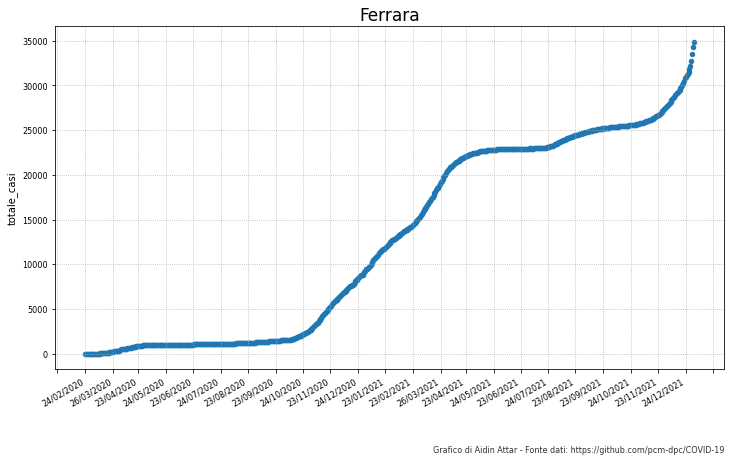

In [5]:
fig, ax = plt.subplots(figsize=(12, 7))

Province['Ferrara'].plot(ax = ax, x ='data', y='totale_casi',
                         kind = 'scatter', title = "Ferrara",
                         xlabel = '')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Ferrara', fontsize=17)
ax.grid(linestyle='dotted')
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

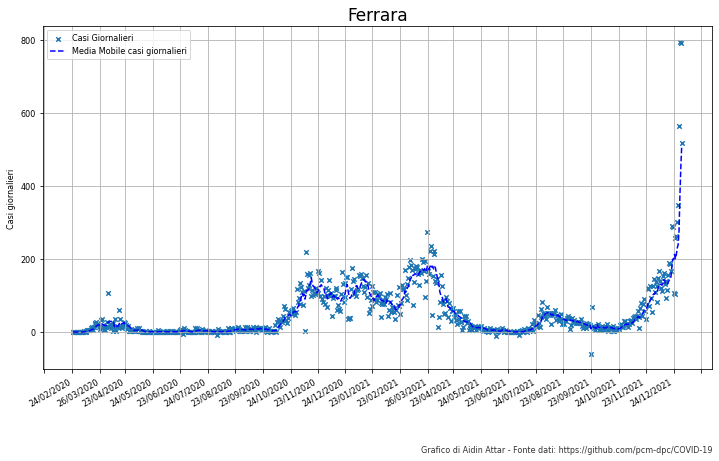

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

Province['Ferrara'].plot(ax = ax, x ='data', y='casi_giornalieri',
             kind = 'scatter', title = "Ferrara", label = 'Casi Giornalieri',
             marker = 'x', color = 'C0',)
Province['Ferrara'].plot(ax = ax, x ='data', y='media_casi_giorn',
             kind = 'line', title = "Ferrara", color = 'blue',
             label = 'Media Mobile casi giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Ferrara', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()


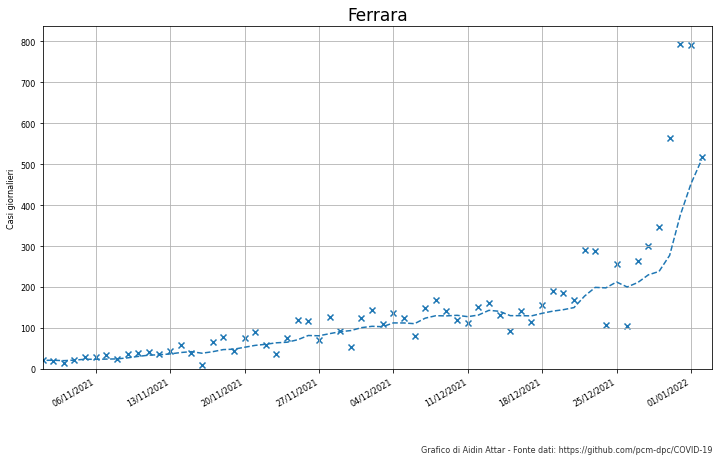

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(Province['Ferrara']['data'], Province['Ferrara']['casi_giornalieri'], marker='x',label = 'Casi giornalieri')
ax.plot(Province['Ferrara']['data'], Province['Ferrara']['media_casi_giorn'], linestyle='dashed',label = 'Media Mobile casi giornalieri')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_title('Ferrara', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.set_xlim([date(2021, 11, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax.set_ylim(bottom=0)
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()


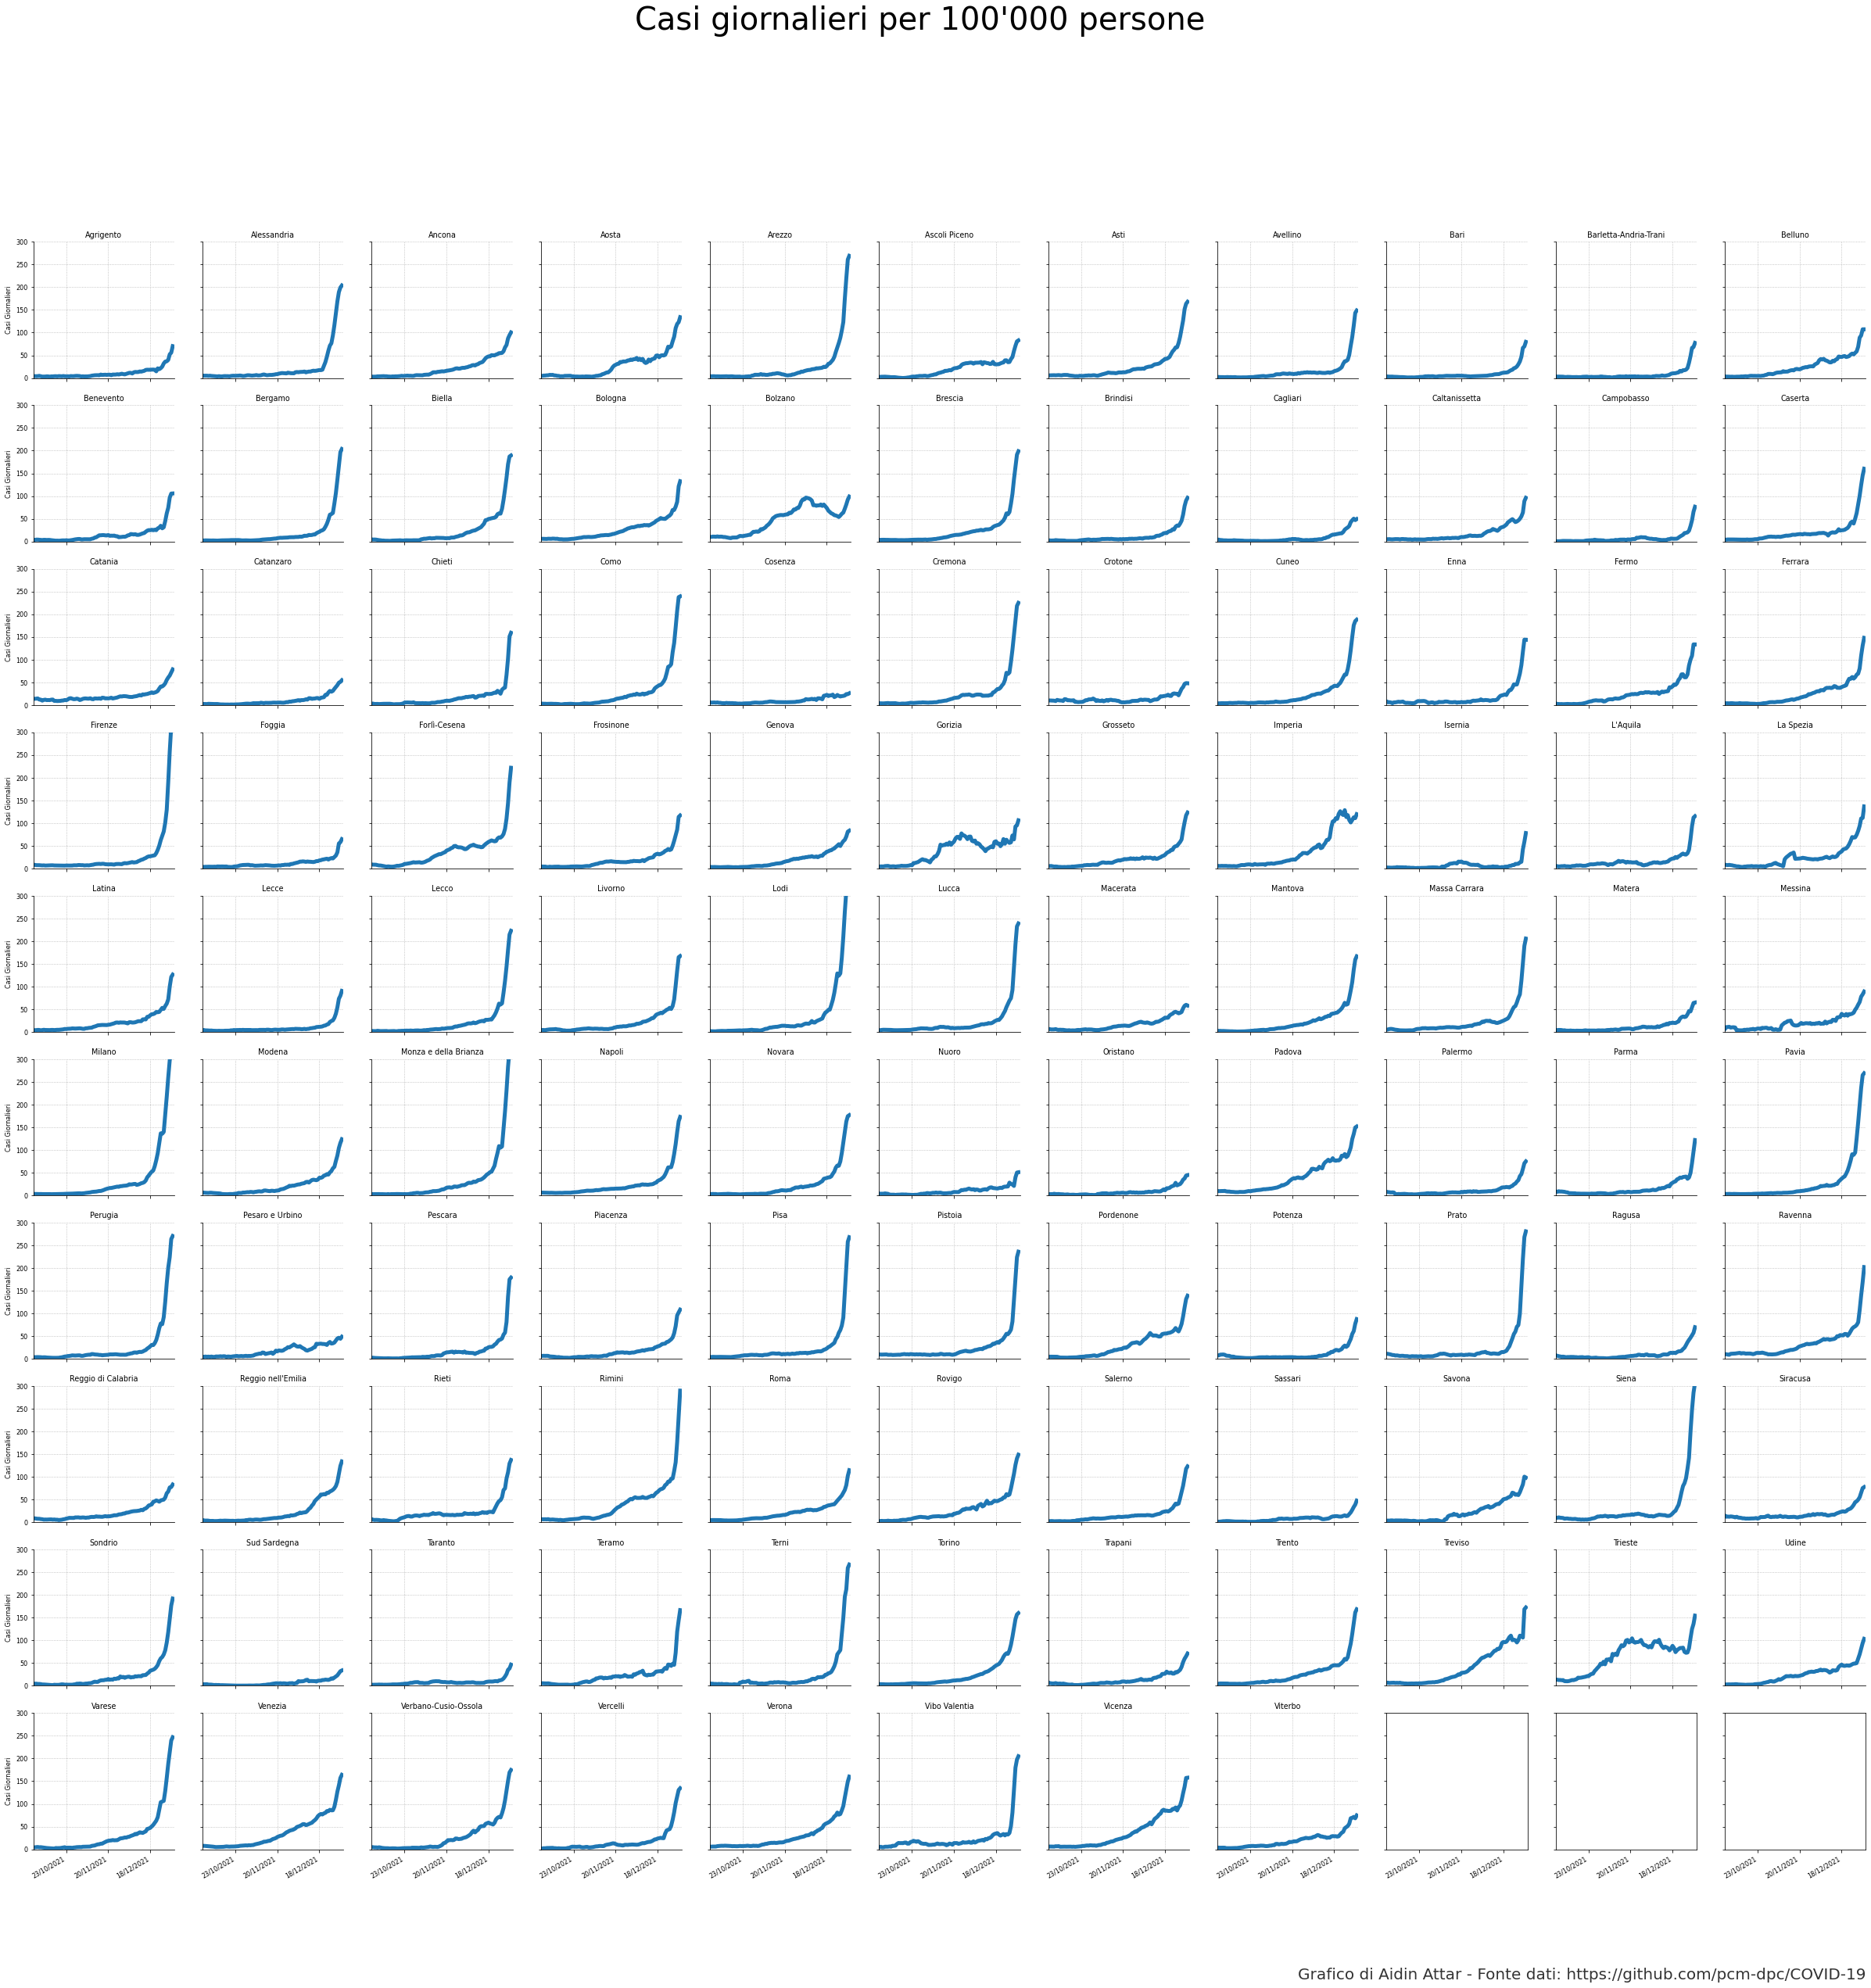

In [8]:
fig, ax = plt.subplots(nrows=10, ncols=11, sharey=True, sharex=True, figsize=(42, 42))

x = 0
y = 0
for key in Province.keys():
    if key != 'In fase di definizione/aggiornamento' and key != 'Fuori Regione / Provincia Autonoma':
        ax[y,x].plot(Province[key]['data'], Province[key]['media_casi_giorn_norm'], linewidth=5)
        ax[y,x].set_title(key)
        ax[y,x].spines['right'].set_visible(False)
        ax[y,x].spines['top'].set_visible(False)
        ax[y,x].spines['left'].set_visible(True)
        ax[y,x].spines['bottom'].set_visible(True)
        ax[y,x].grid(linestyle='dotted')
        #ax[y,x].axis('off')
        x += 1
        if x == 11:
            y +=1
            x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Casi Giornalieri')
ax[1,0].set_ylabel('Casi Giornalieri')
ax[2,0].set_ylabel('Casi Giornalieri')
ax[3,0].set_ylabel('Casi Giornalieri')
ax[4,0].set_ylabel('Casi Giornalieri')
ax[5,0].set_ylabel('Casi Giornalieri')
ax[6,0].set_ylabel('Casi Giornalieri')
ax[7,0].set_ylabel('Casi Giornalieri')
ax[8,0].set_ylabel('Casi Giornalieri')
ax[9,0].set_ylabel('Casi Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Casi giornalieri per 100'000 persone", fontsize=40)
ax[0,0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax[0,0].set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax[0,0].set_ylim([0, 300])
plt.text(0.9, 0.15, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure, fontsize=20, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

In [9]:
NomiRegioni = regioni.denominazione_regione.unique()
PopoRegioni = [1312000,562869,1947000,5802000,4459000,1215000,5879000,1551000,10060000,1525000,305617,520891,538223,4356000,4029000,1640000,5000000,3730000,882015,125666,4906000]
DictRegioni = dict(zip(NomiRegioni, PopoRegioni))

#create a data frame dictionary to store your data frames
Regioni = {elem : pd.DataFrame for elem in NomiRegioni}
for key in Regioni.keys():
    Regioni[key] = regioni[:][regioni.denominazione_regione == key]
    Regioni[key]['data']                  = pd.to_datetime(Regioni[key]['data'],format='%Y-%m-%dT%H:%M:%S',yearfirst=True, dayfirst=True)
    Regioni[key]['new_date']              = Regioni[key]['data'].dt.date
    Regioni[key]                          = Regioni[key].set_index('new_date')
    Regioni[key].sort_index(inplace=True)
    Regioni[key]                          = Regioni[key].reindex(idx)
    Regioni[key].index                    = Regioni[key].index.strftime('%d/%m/%Y')

    Regioni[key]['casi_giornalieri']         = Regioni[key]['totale_casi'] - Regioni[key]['totale_casi'].shift(1)
    Regioni[key]['media_casi_giorn']         = Regioni[key]['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['morti_giornalieri']        = Regioni[key]['deceduti'] - Regioni[key]['deceduti'].shift(1)
    Regioni[key]['media_morti_giorn']        = Regioni[key]['morti_giornalieri'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['casi_giornalieri_norm']    = Regioni[key]['casi_giornalieri'] / DictRegioni[key] * 1e5
    Regioni[key]['media_casi_giorn_norm']    = Regioni[key]['media_casi_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['morti_giornalieri_norm']   = Regioni[key]['morti_giornalieri'] / DictRegioni[key] * 1e5
    Regioni[key]['media_morti_giorn_norm']   = Regioni[key]['media_morti_giorn'] / DictRegioni[key] * 1e5

    Regioni[key]['tamponi_giornalieri']      = Regioni[key]['tamponi'] - Regioni[key]['tamponi'].shift(1)
    Regioni[key]['media_tamponi']            = Regioni[key]['tamponi_giornalieri'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_positivi']           = Regioni[key]['casi_giornalieri'] / Regioni[key]['tamponi_giornalieri'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_positivi < 0].index, inplace=True)
    Regioni[key]['media_tasso_positivi']     = Regioni[key]['tasso_positivi'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tamponi_giornalieri_norm'] = Regioni[key]['tamponi_giornalieri'] / DictRegioni[key] * 1e5
    Regioni[key]['media_tamponi_giorn_norm'] = Regioni[key]['media_tamponi'] / DictRegioni[key] * 1e5

    Regioni[key]['casi_testati_giorn']       = Regioni[key]['casi_testati'] - Regioni[key]['casi_testati'].shift(1)
    Regioni[key]['media_casi_testati']       = Regioni[key]['casi_testati_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_casi']               = Regioni[key]['casi_giornalieri'] / Regioni[key]['casi_testati_giorn'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_casi < 0].index, inplace=True)
    Regioni[key]['media_tasso_casi']         = Regioni[key]['tasso_casi'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['casi_testati_norm']        = Regioni[key]['casi_testati_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['media_casi_testati_norm']  = Regioni[key]['media_casi_testati'] / DictRegioni[key] * 1e5

    Regioni[key]['tamponi_test_molecolare_giorn']         = Regioni[key]['tamponi_test_molecolare']         - Regioni[key]['tamponi_test_molecolare'].shift(1)
    Regioni[key]['media_tamponi_test_molecolare_giorn'] = Regioni[key]['tamponi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['totale_positivi_test_molecolare_giorn'] = Regioni[key]['totale_positivi_test_molecolare'] - Regioni[key]['totale_positivi_test_molecolare'].shift(1)
    Regioni[key]['media_pos_molecolare']                  = Regioni[key]['totale_positivi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_molecolare']                      = Regioni[key]['totale_positivi_test_molecolare_giorn'] / Regioni[key]['tamponi_test_molecolare_giorn'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_molecolare < 0].index, inplace=True)
    Regioni[key]['media_tasso_molecolare']                = Regioni[key]['tasso_molecolare'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tamponi_test_molecolare_giorn_norm']        = Regioni[key]['tamponi_test_molecolare_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['media_tamponi_test_molecolare_giorn_norm']  = Regioni[key]['media_tamponi_test_molecolare_giorn'] / DictRegioni[key] * 1e5

    Regioni[key]['tamponi_test_antigenico_rapido_giorn']  = Regioni[key]['tamponi_test_antigenico_rapido']  - Regioni[key]['tamponi_test_antigenico_rapido'].shift(1)
    Regioni[key]['media_test_antigenico_rapido_giorn'] = Regioni[key]['tamponi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['totale_positivi_test_antigenico_rapido_giorn'] = Regioni[key]['totale_positivi_test_antigenico_rapido'] - Regioni[key]['totale_positivi_test_antigenico_rapido'].shift(1)
    Regioni[key]['media_pos_antigenico_rapido']                  = Regioni[key]['totale_positivi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tasso_antigenico_rapido']                      = Regioni[key]['totale_positivi_test_antigenico_rapido_giorn'] / Regioni[key]['tamponi_test_antigenico_rapido_giorn'] * 100
    Regioni[key].drop(Regioni[key][Regioni[key].tasso_antigenico_rapido < 0].index, inplace=True)
    Regioni[key]['media_tasso_antigenico_rapido']                = Regioni[key]['tasso_antigenico_rapido'].rolling(window=7, min_periods=1).mean()
    Regioni[key]['tamponi_test_antigenico_rapido_giorn_norm']        = Regioni[key]['tamponi_test_antigenico_rapido_giorn'] / DictRegioni[key] * 1e5
    Regioni[key]['media_test_antigenico_rapido_giorn_norm']  = Regioni[key]['media_test_antigenico_rapido_giorn'] / DictRegioni[key] * 1e5

    Regioni[key]['media_ingressi_terapia_intensiva'] = Regioni[key]['ingressi_terapia_intensiva'].rolling(window=7, min_periods=1).mean()


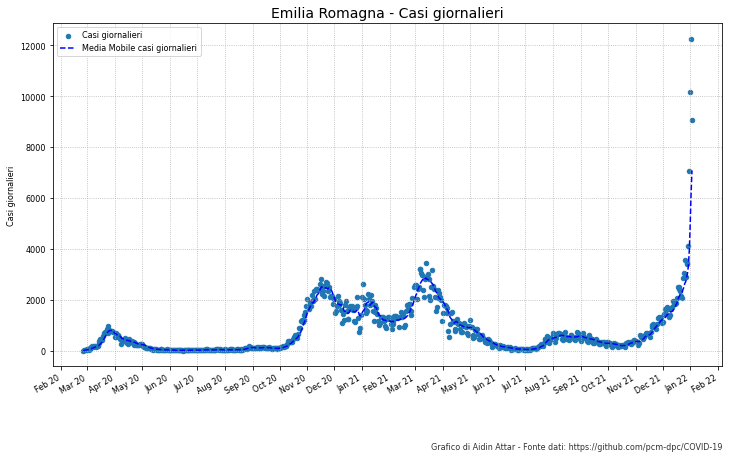

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))

Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='casi_giornalieri',
                               kind='scatter', label='Casi giornalieri',  color='C0')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_casi_giorn'],
        color = 'blue', label = 'Media Mobile casi giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Emilia Romagna - Casi giornalieri', fontsize=14)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

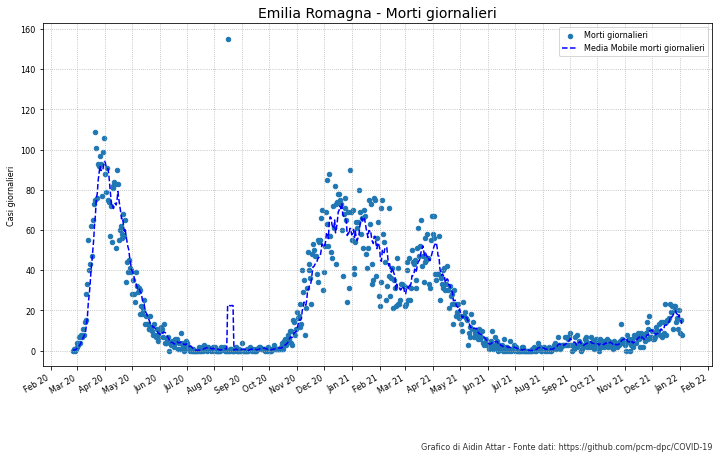

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))

Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='morti_giornalieri',
                               kind='scatter', label='Morti giornalieri',  color='C0')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_morti_giorn'],
        color = 'blue', label = 'Media Mobile morti giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Emilia Romagna - Morti giornalieri', fontsize=14)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
ax.legend()
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

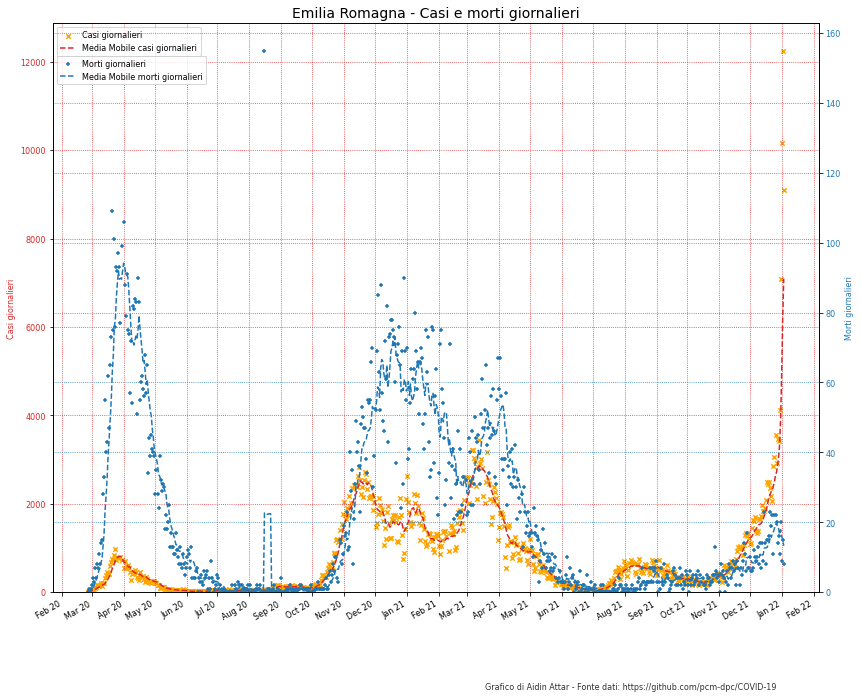

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Casi giornalieri', color=color)
Regioni['Emilia-Romagna'].plot(ax=ax1, x ='data', y='casi_giornalieri',
                               kind='scatter', label='Casi giornalieri',  color='orange',
                               marker='x', ylabel='Casi giornalieri', xlabel='')
ax1.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_casi_giorn'],
        color = color, label = 'Media Mobile casi giornalieri', linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Morti giornalieri', color=color)

Regioni['Emilia-Romagna'].plot(ax=ax2, x ='data', y='morti_giornalieri',
                               kind='scatter', label='Morti giornalieri',  color='C0',
                               marker='+', ylabel='Morti giornalieri', xlabel='')
ax2.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_morti_giorn'],
        color = color, label = 'Media Mobile morti giornalieri', linestyle='dashed')

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_title('Emilia Romagna - Casi e morti giornalieri', fontsize=14)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [13]:
italia['casi_giornalieri']                 = italia['totale_casi'] - italia['totale_casi'].shift(1)
italia['media_casi_giorn']                 = italia['casi_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['morti_giornalieri']                = italia['deceduti'] - italia['deceduti'].shift(1)
italia['media_morti_giorn']                = italia['morti_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['media_ingressi_terapia_intensiva'] = italia['ingressi_terapia_intensiva'].rolling(window=7, min_periods=1).mean()


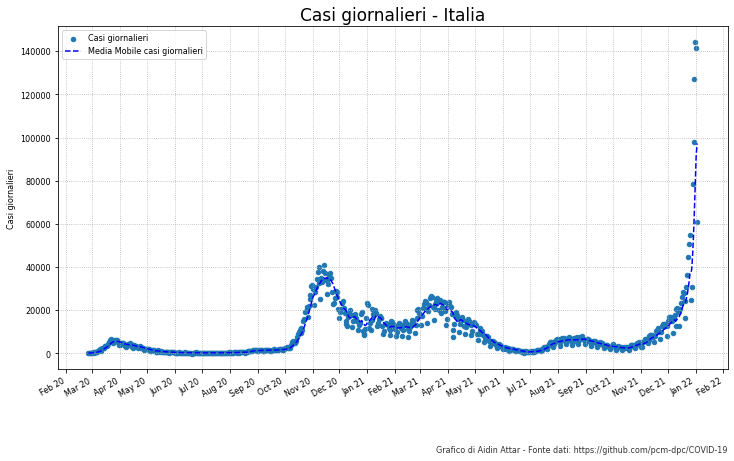

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='casi_giornalieri',
                               kind='scatter', label='Casi giornalieri',  color='C0')
ax.plot(italia['data'], italia['media_casi_giorn'],
        color = 'blue', label = 'Media Mobile casi giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Casi giornalieri - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

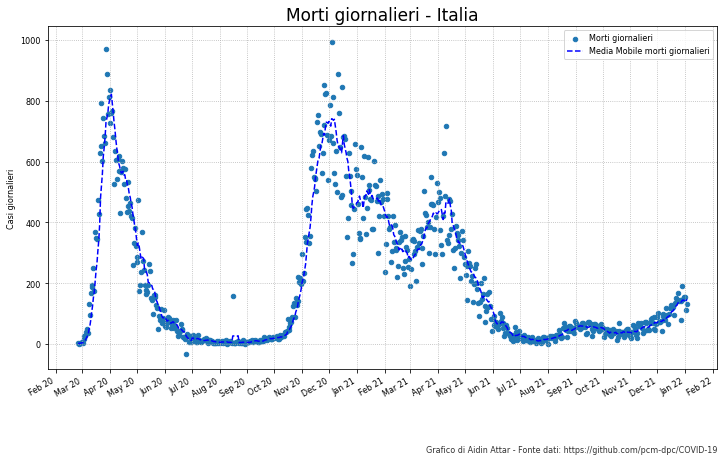

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='morti_giornalieri',
            kind='scatter', label='Morti giornalieri',  color='C0')
ax.plot(italia['data'], italia['media_morti_giorn'],
        color = 'blue', label = 'Media Mobile morti giornalieri', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Morti giornalieri - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Casi giornalieri')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

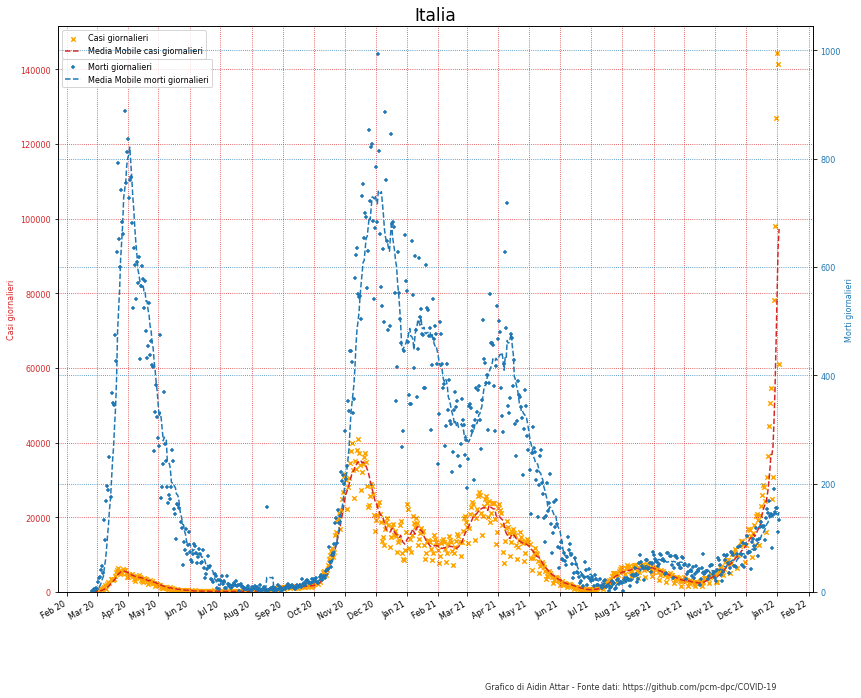

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Casi giornalieri', color=color)
italia.plot(ax=ax1, x ='data', y='casi_giornalieri', 
                               kind='scatter', label='Casi giornalieri',  color='orange',
                               marker='x', ylabel='Casi giornalieri', xlabel='')
ax1.plot(italia['data'], italia['media_casi_giorn'],
        color = color, label = 'Media Mobile casi giornalieri', linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Morti giornalieri', color=color)

italia.plot(ax=ax2, x ='data', y='morti_giornalieri', 
                               kind='scatter', label='Morti giornalieri',  color='C0',
                               marker='+', ylabel='Morti giornalieri', xlabel='')
ax2.plot(italia['data'], italia['media_morti_giorn'],
        color = color, label = 'Media Mobile morti giornalieri', linestyle='dashed')

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))

ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


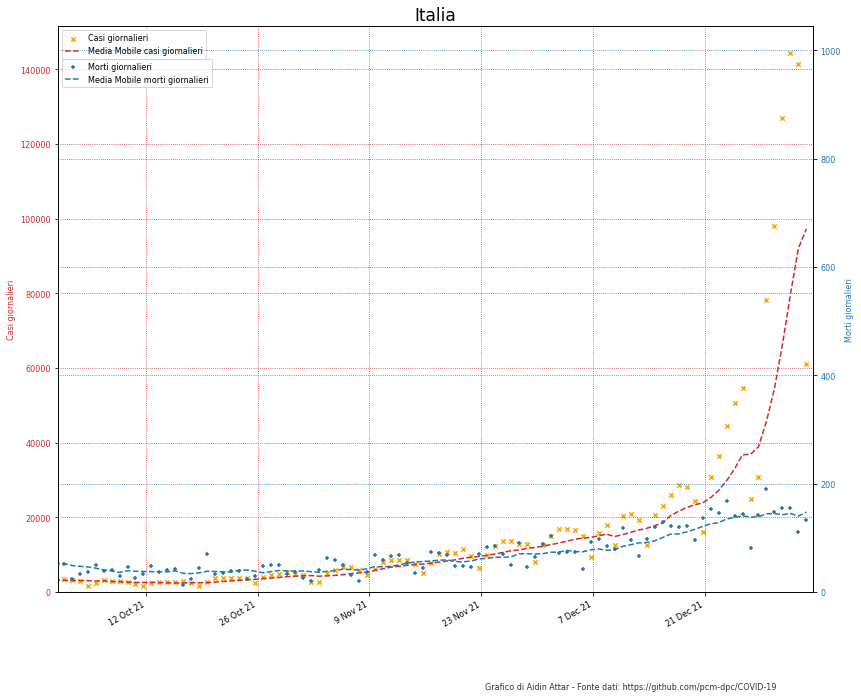

In [17]:
today = datetime.today()
yesterday = (date.today() - timedelta(days=1))
fig, ax1 = plt.subplots(figsize=(12, 10))

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Casi giornalieri', color=color)
italia.plot(ax=ax1, x ='data', y='casi_giornalieri',
            kind='scatter', label='Casi giornalieri',  color='orange',
            marker='x', ylabel='Casi giornalieri', xlabel='')
ax1.plot(italia['data'], italia['media_casi_giorn'],
         color = color, label = 'Media Mobile casi giornalieri', linestyle='dashed')

ax1.set_xlim([date(2021, 10, 1), today])
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Morti giornalieri', color=color)

italia.plot(ax=ax2, x ='data', y='morti_giornalieri',
                               kind='scatter', label='Morti giornalieri',  color='C0',
                               marker='+', ylabel='Morti giornalieri', xlabel='')
ax2.plot(italia['data'], italia['media_morti_giorn'],
        color = color, label = 'Media Mobile morti giornalieri', linestyle='dashed')

fig.autofmt_xdate()
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
ax2.grid(linestyle='dotted', color=color)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [18]:
italia['tamponi_giornalieri'] = italia['tamponi'] - italia['tamponi'].shift(1)
italia['media_tamponi']       = italia['tamponi_giornalieri'].rolling(window=7, min_periods=1).mean()
italia['tasso_positivi']      = italia['casi_giornalieri'] / italia['tamponi_giornalieri'] * 100
italia.drop(italia[italia.tasso_positivi < 0].index, inplace=True)
italia['media_tasso_positivi']     = italia['tasso_positivi'].rolling(window=7, min_periods=1).mean()

italia['casi_testati_giorn'] = italia['casi_testati'] - italia['casi_testati'].shift(1)
italia['media_casi_testati'] = italia['casi_testati_giorn'].rolling(window=7, min_periods=1).mean()
italia['tasso_casi']         = italia['casi_giornalieri'] / italia['casi_testati_giorn'] * 100
italia.drop(italia[italia.tasso_casi < 0].index, inplace=True)
italia['media_tasso_casi']   = italia['tasso_casi'].rolling(window=7, min_periods=1).mean()

italia['tamponi_test_molecolare_giorn']         = italia['tamponi_test_molecolare']         - italia['tamponi_test_molecolare'].shift(1)
italia['media_tamponi_test_molecolare_giorn'] = italia['tamponi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
italia['totale_positivi_test_molecolare_giorn'] = italia['totale_positivi_test_molecolare'] - italia['totale_positivi_test_molecolare'].shift(1)
italia['media_pos_molecolare']                  = italia['totale_positivi_test_molecolare_giorn'].rolling(window=7, min_periods=1).mean()
italia['tasso_molecolare']                      = italia['totale_positivi_test_molecolare_giorn'] / italia['tamponi_test_molecolare_giorn'] * 100
italia.drop(italia[italia.tasso_molecolare < 0].index, inplace=True)
italia['media_tasso_molecolare']                = italia['tasso_molecolare'].rolling(window=7, min_periods=1).mean()

italia['tamponi_test_antigenico_rapido_giorn']  = italia['tamponi_test_antigenico_rapido']  - italia['tamponi_test_antigenico_rapido'].shift(1)
italia['media_test_antigenico_rapido_giorn'] = italia['tamponi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
italia['totale_positivi_test_antigenico_rapido_giorn'] = italia['totale_positivi_test_antigenico_rapido'] - italia['totale_positivi_test_antigenico_rapido'].shift(1)
italia['media_pos_antigenico_rapido']                  = italia['totale_positivi_test_antigenico_rapido_giorn'].rolling(window=7, min_periods=1).mean()
italia['tasso_antigenico_rapido']                      = italia['totale_positivi_test_antigenico_rapido_giorn'] / italia['tamponi_test_antigenico_rapido_giorn'] * 100
italia.drop(italia[italia.tasso_molecolare < 0].index, inplace=True)
italia['media_tasso_antigenico_rapido']                = italia['tasso_antigenico_rapido'].rolling(window=7, min_periods=1).mean()



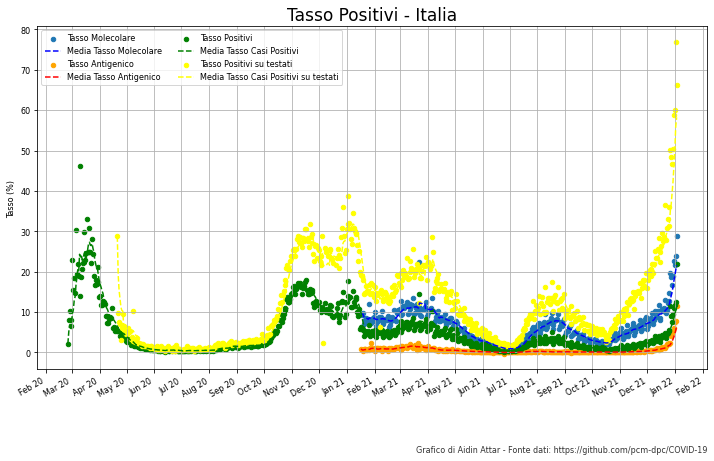

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='tasso_molecolare',
                               kind='scatter', label='Tasso Molecolare',  color='C0')
ax.plot(italia['data'], italia['media_tasso_molecolare'],
        color = 'blue', label = 'Media Tasso Molecolare', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tasso_antigenico_rapido',
                               kind='scatter', label='Tasso Antigenico',  color='orange')
ax.plot(italia['data'], italia['media_tasso_antigenico_rapido'],
        color = 'red', label = 'Media Tasso Antigenico', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tasso_positivi',
                               kind='scatter', label='Tasso Positivi',  color='green')
ax.plot(italia['data'], italia['media_tasso_positivi'],
        color = 'green', label = 'Media Tasso Casi Positivi', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tasso_casi',
                               kind='scatter', label='Tasso Positivi su testati',  color='yellow')
ax.plot(italia['data'], italia['media_tasso_casi'],
        color = 'yellow', label = 'Media Tasso Casi Positivi su testati', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Tasso Positivi - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Tasso (%)')
ax.set_xlabel("")
ax.legend(loc='upper left', ncol=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

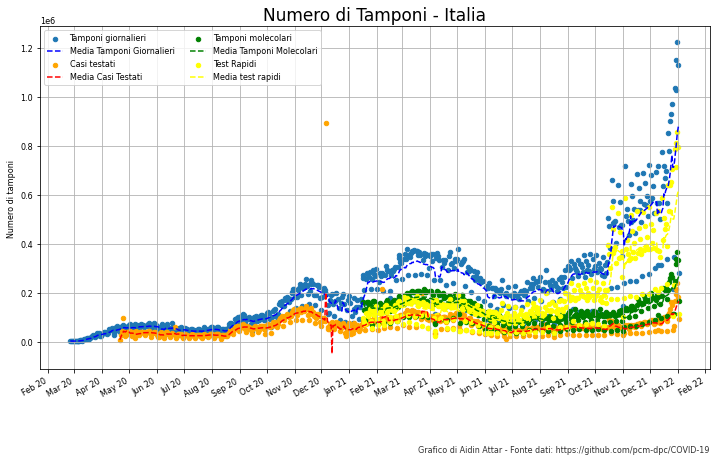

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='tamponi_giornalieri',
                               kind='scatter', label='Tamponi giornalieri',  color='C0')
ax.plot(italia['data'], italia['media_tamponi'],
        color = 'blue', label = 'Media Tamponi Giornalieri', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='casi_testati_giorn',
                               kind='scatter', label='Casi testati',  color='orange')
ax.plot(italia['data'], italia['media_casi_testati'],
        color = 'red', label = 'Media Casi Testati', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tamponi_test_molecolare_giorn',
                               kind='scatter', label='Tamponi molecolari',  color='green')
ax.plot(italia['data'], italia['media_tamponi_test_molecolare_giorn'],
        color = 'green', label = 'Media Tamponi Molecolari', linestyle='dashed')
italia.plot(ax=ax, x ='data', y='tamponi_test_antigenico_rapido_giorn',
                               kind='scatter', label='Test Rapidi',  color='yellow')
ax.plot(italia['data'], italia['media_test_antigenico_rapido_giorn'],
        color = 'yellow', label = 'Media test rapidi', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Numero di Tamponi - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Numero di tamponi')
ax.set_xlabel("")
ax.legend(loc='best', ncol=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

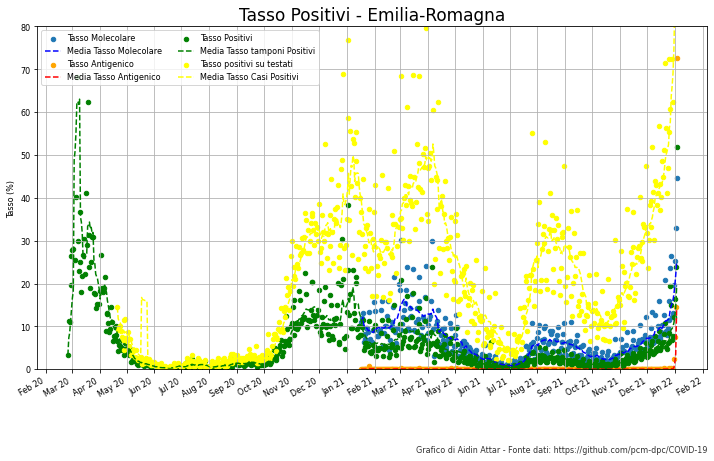

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_molecolare',
                               kind='scatter', label='Tasso Molecolare',  color='C0')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_molecolare'],
        color = 'blue', label = 'Media Tasso Molecolare', linestyle='dashed')
Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_antigenico_rapido',
                               kind='scatter', label='Tasso Antigenico',  color='orange')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_antigenico_rapido'],
        color = 'red', label = 'Media Tasso Antigenico', linestyle='dashed')
Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_positivi',
                               kind='scatter', label='Tasso Positivi',  color='green')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_positivi'],
        color = 'green', label = 'Media Tasso tamponi Positivi', linestyle='dashed')
Regioni['Emilia-Romagna'].plot(ax=ax, x ='data', y='tasso_casi',
                               kind='scatter', label='Tasso positivi su testati',  color='yellow')
ax.plot(Regioni['Emilia-Romagna']['data'], Regioni['Emilia-Romagna']['media_tasso_casi'],
        color = 'yellow', label = 'Media Tasso Casi Positivi', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_title('Tasso Positivi - Emilia-Romagna', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid('dotted')
ax.set_ylabel('Tasso (%)')
ax.set_ylim([0,80])
ax.set_xlabel("")
ax.legend(loc='best', ncol=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

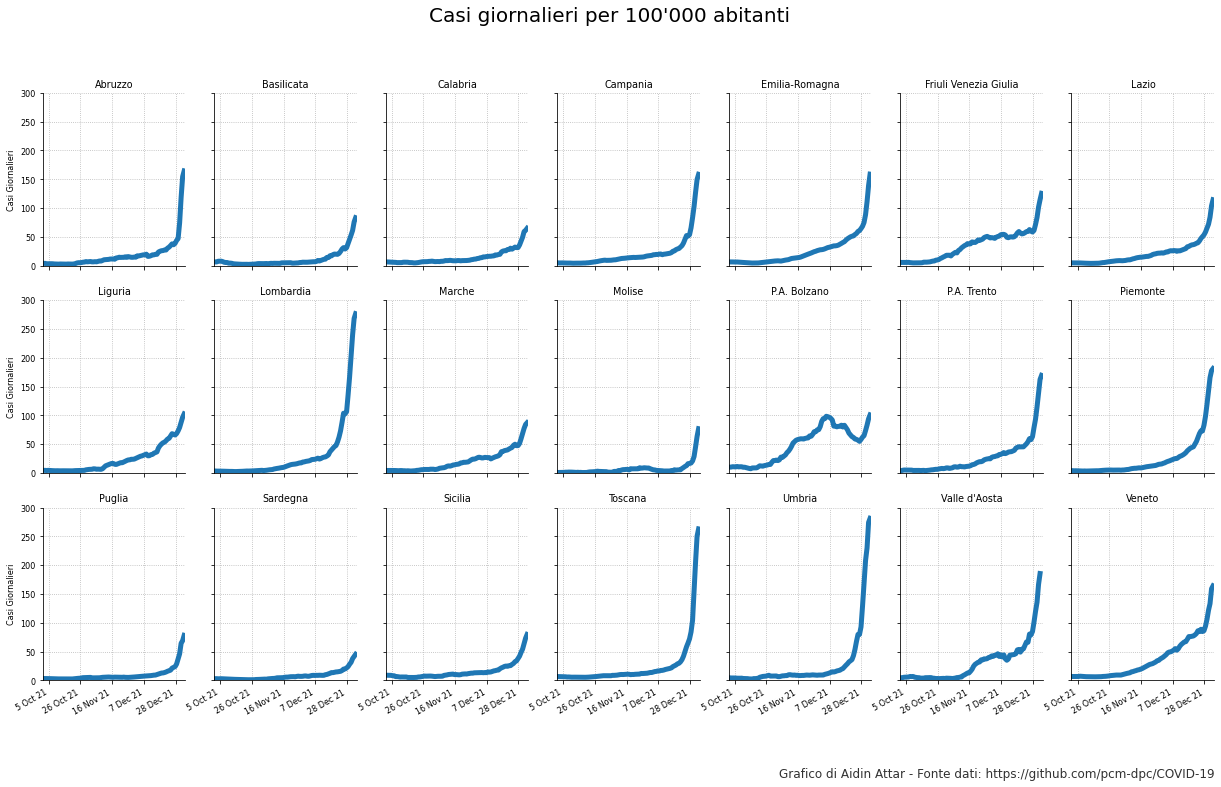

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'],c='C0', lw=5)
    #ax[y,x].plot(Regioni[key]['data'], Regioni[key]['media_morti_giorn_norm'],c='orange')
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Casi Giornalieri')
ax[1,0].set_ylabel('Casi Giornalieri')
ax[2,0].set_ylabel('Casi Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Casi giornalieri per 100'000 abitanti", fontsize=20)
ax[0,0].set_ylim(bottom=0, top=300)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

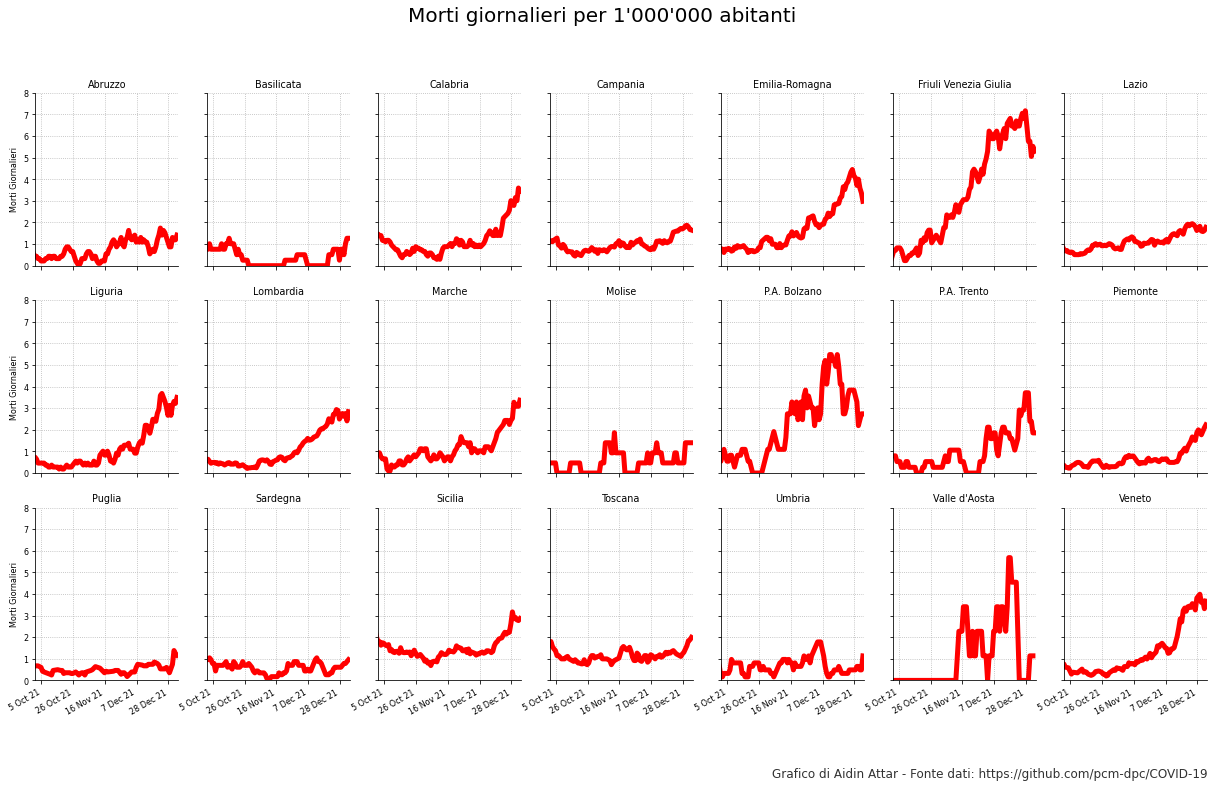

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    #ax[y,x].plot(Regioni[key]['data'], Regioni[key]['media_casi_giorn_norm'],c='C0', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_morti_giorn_norm']*10,c='red', lw=5)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Morti Giornalieri')
ax[1,0].set_ylabel('Morti Giornalieri')
ax[2,0].set_ylabel('Morti Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Morti giornalieri per 1'000'000 abitanti", fontsize=20)
ax[0,0].set_ylim(bottom=0, top=8)
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

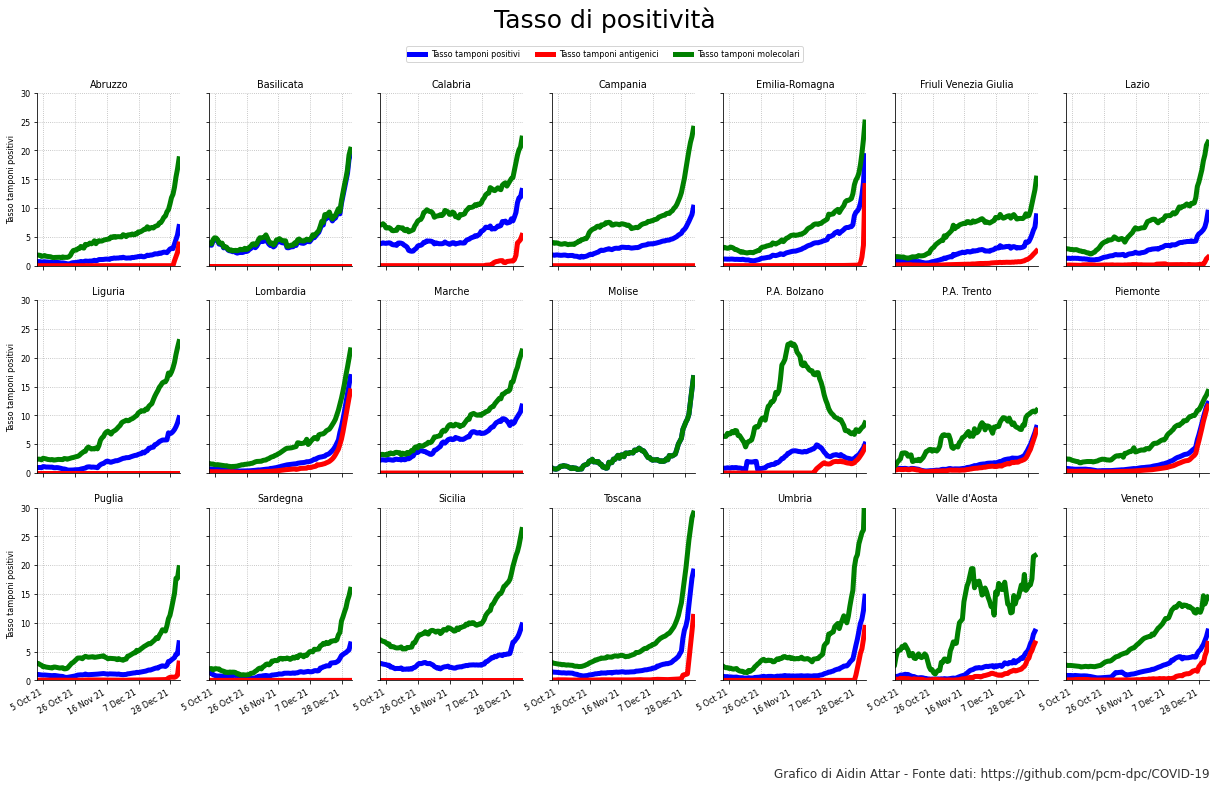

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    #ax[y,x].plot(Regioni[key]['data'], Regioni[key]['media_casi_giorn_norm'],c='C0', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tasso_positivi'],c='blue', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tasso_antigenico_rapido'],c='red', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tasso_molecolare'],c='green', lw=5)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Tasso tamponi positivi')
ax[1,0].set_ylabel('Tasso tamponi positivi')
ax[2,0].set_ylabel('Tasso tamponi positivi')
fig.autofmt_xdate()
fig.suptitle("Tasso di positività", fontsize=25)
ax[0,0].set_ylim(bottom=0, top=30)

labels = ['Tasso tamponi positivi', 'Tasso tamponi antigenici', 'Tasso tamponi molecolari']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

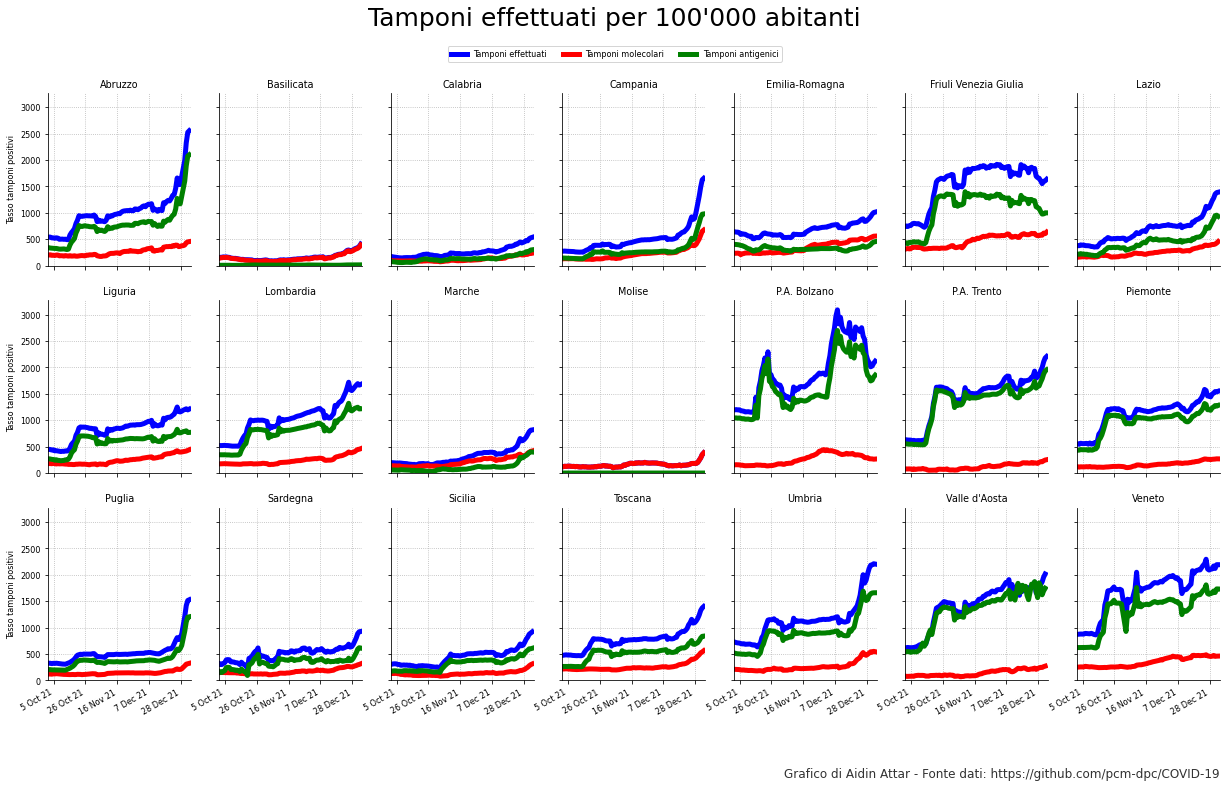

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tamponi_giorn_norm'],c='blue', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_tamponi_test_molecolare_giorn_norm'],c='red', lw=5)
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_test_antigenico_rapido_giorn_norm'],c='green', lw=5)
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax[y,x].set_xlim([date(2021, 10, 1), today])
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%-d %b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Tasso tamponi positivi')
ax[1,0].set_ylabel('Tasso tamponi positivi')
ax[2,0].set_ylabel('Tasso tamponi positivi')
ax[0,0].set_ylim(bottom=0)
fig.autofmt_xdate()
fig.suptitle("Tamponi effettuati per 100'000 abitanti", fontsize=25)

labels = ['Tamponi effettuati', 'Tamponi molecolari', 'Tamponi antigenici']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

plt.show()

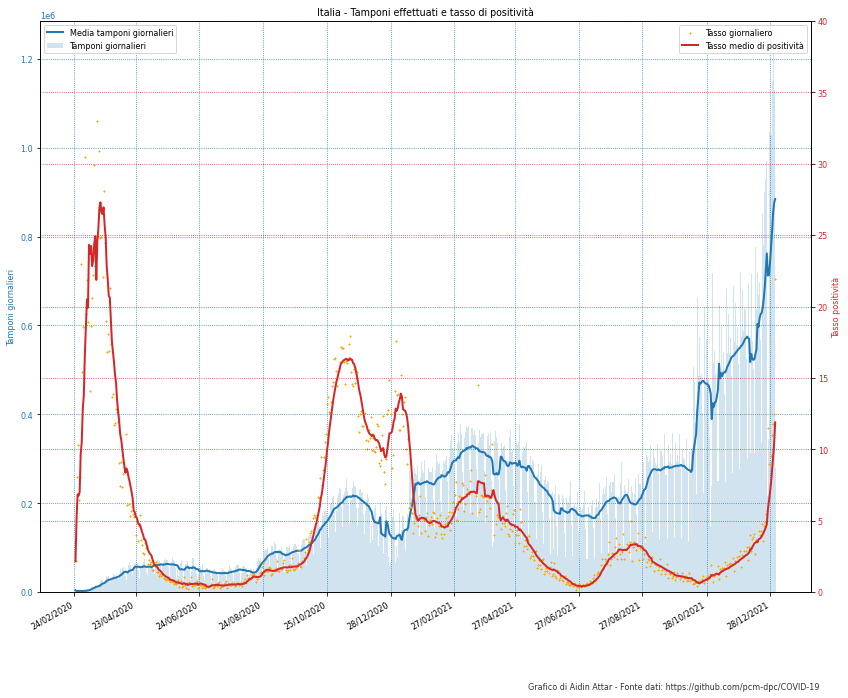

In [26]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(italia.index, italia.tamponi_giornalieri,
        color='C0', width=1, label='Tamponi giornalieri', alpha=0.2)
ax1.plot(italia.index, italia.media_tamponi,
         color=color, label = 'Media tamponi giornalieri', lw = 2)

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Italia - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=italia.index, y=italia.tasso_positivi,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(italia.index, italia.media_tasso_positivi,
         color = color, linewidth = 2, label = 'Tasso medio di positività')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0,top=40)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

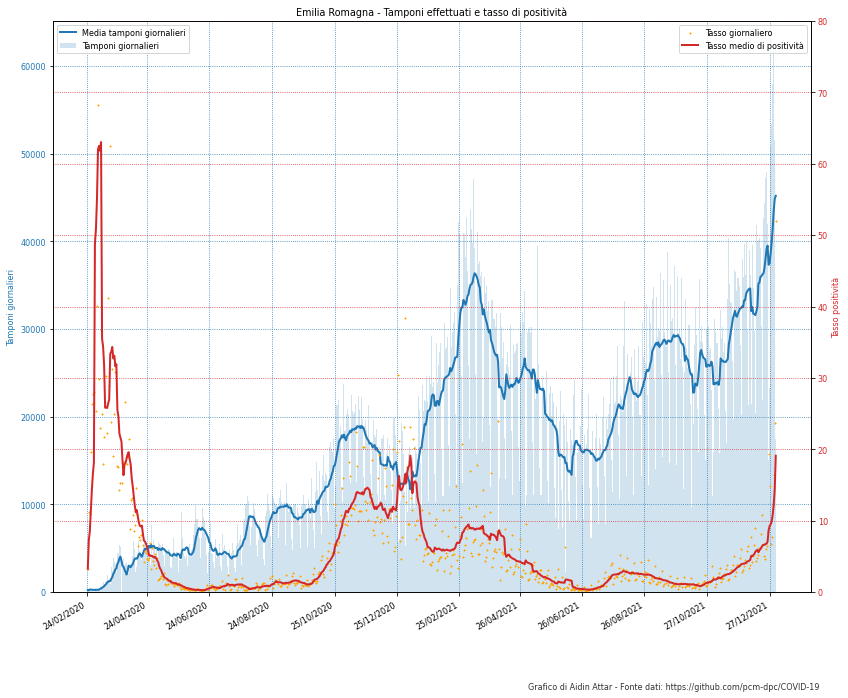

In [27]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].tamponi_giornalieri,
        color='C0', width=1, label='Tamponi giornalieri', alpha=0.2)
ax1.plot(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].media_tamponi,
         color=color, label = 'Media tamponi giornalieri', lw=2)

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Emilia Romagna - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=Regioni['Emilia-Romagna'].index, y=Regioni['Emilia-Romagna'].tasso_positivi,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].media_tasso_positivi,
         color = color, linewidth = 2, label = 'Tasso medio di positività')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

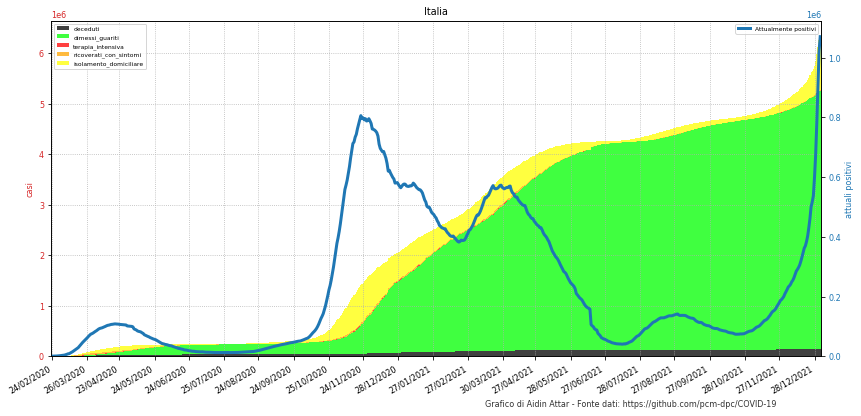

In [28]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
italia[['deceduti',
        'dimessi_guariti',
        'terapia_intensiva',
        'ricoverati_con_sintomi',
        'isolamento_domiciliare']].plot.bar(ax=ax1, width = 1,stacked = True,
                                            color = ['black', 'lime', 'red', 'orange', 'yellow'],
                                            label = ['Decessi', 'Dimessi guariti', 'Terapie intensive', 'Ricoverati con sintomi', 'Isolamento domiciliare'],
                                            alpha = 0.75,
                                            xlabel='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('casi', color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
italia.plot(ax = ax2, y='totale_positivi',
         kind = 'line',title = "Italia",
         xlabel = '',  color=color,
         linewidth = 3, label = 'Attualmente positivi')

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('attuali positivi', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.rcParams['font.size'] = '8'
plt.text(0.9, 0.07, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left', prop={'size': 6})
ax2.legend(loc='upper right',prop={'size': 6})
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

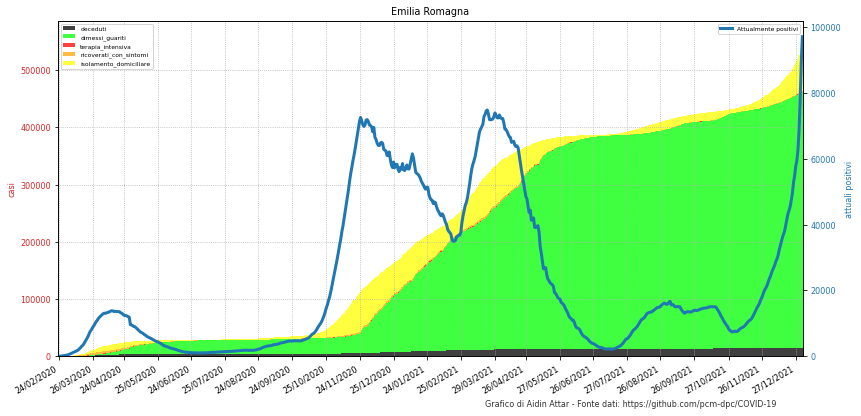

In [29]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
Regioni['Emilia-Romagna'][['deceduti',
        'dimessi_guariti',
        'terapia_intensiva',
        'ricoverati_con_sintomi',
        'isolamento_domiciliare']].plot.bar(ax=ax1, width = 1,stacked = True,
                                            color = ['black', 'lime', 'red', 'orange', 'yellow'],
                                            label = ['Decessi', 'Dimessi guariti', 'Terapie intensive', 'Ricoverati con sintomi', 'Isolamento domiciliare'],
                                            alpha = 0.75,
                                            xlabel='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('casi', color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
Regioni['Emilia-Romagna'].plot(ax = ax2, y='totale_positivi',
         kind = 'line',title = "Emilia Romagna",
         xlabel = '',  color=color,
         linewidth = 3, label = 'Attualmente positivi')

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('attuali positivi', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.rcParams['font.size'] = '8'
plt.text(0.9, 0.07, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left', prop={'size': 6})
ax2.legend(loc='upper right',prop={'size': 6})
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [30]:
'''
italia['incremento_casi_giornalieri']        = italia['casi_giornalieri']  / italia['casi_giornalieri' ].shift(7)
italia['incremento_morti_giornalieri']       = italia['morti_giornalieri'] / italia['morti_giornalieri'].shift(7)
italia['media_incremento_casi_giornalieri']  = italia['incremento_casi_giornalieri' ].rolling(window=20, min_periods=1).mean()
italia['media_incremento_morti_giornalieri'] = italia['incremento_morti_giornalieri'].rolling(window=20, min_periods=1).mean()

for key in Regioni.keys():
    Regioni[key]['incremento_casi_giornalieri']        = Regioni[key]['casi_giornalieri']  / Regioni[key]['casi_giornalieri' ].shift(7)
    Regioni[key]['incremento_morti_giornalieri']       = Regioni[key]['morti_giornalieri'] / Regioni[key]['morti_giornalieri'].shift(7)
    Regioni[key]['media_incremento_casi_giornalieri']  = Regioni[key]['incremento_casi_giornalieri' ].rolling(window=30, min_periods=1).mean()
    Regioni[key]['media_incremento_morti_giornalieri'] = Regioni[key]['incremento_morti_giornalieri'].rolling(window=30, min_periods=1).mean()

'''
italia['incremento_casi_giornalieri']        = italia['media_casi_giorn']  / italia['media_casi_giorn' ].shift(7)
italia['incremento_morti_giornalieri']       = italia['media_morti_giorn'] / italia['media_morti_giorn'].shift(7)
italia['media_incremento_casi_giornalieri']  = italia['incremento_casi_giornalieri' ].rolling(window=10, min_periods=1).mean()
italia['media_incremento_morti_giornalieri'] = italia['incremento_morti_giornalieri'].rolling(window=10, min_periods=1).mean()

for key in Regioni.keys():
    Regioni[key]['incremento_casi_giornalieri']        = Regioni[key]['media_casi_giorn']  / Regioni[key]['media_casi_giorn' ].shift(7)
    Regioni[key]['incremento_morti_giornalieri']       = Regioni[key]['media_morti_giorn'] / Regioni[key]['media_morti_giorn'].shift(7)
    Regioni[key]['media_incremento_casi_giornalieri']  = Regioni[key]['incremento_casi_giornalieri' ].rolling(window=10, min_periods=1).mean()
    Regioni[key]['media_incremento_morti_giornalieri'] = Regioni[key]['incremento_morti_giornalieri'].rolling(window=10, min_periods=1).mean()


italia

data stato  ricoverati_con_sintomi  \
24/02/2020 2020-02-24 18:00:00   ITA                     101   
25/02/2020 2020-02-25 18:00:00   ITA                     114   
26/02/2020 2020-02-26 18:00:00   ITA                     128   
27/02/2020 2020-02-27 18:00:00   ITA                     248   
28/02/2020 2020-02-28 18:00:00   ITA                     345   
...                        ...   ...                     ...   
29/12/2021 2021-12-29 17:00:00   ITA                   10578   
30/12/2021 2021-12-30 17:00:00   ITA                   10866   
31/12/2021 2021-12-31 17:00:00   ITA                   11150   
01/01/2022 2022-01-01 17:00:00   ITA                   11265   
02/01/2022 2022-01-02 17:00:00   ITA                   11756   

            terapia_intensiva  totale_ospedalizzati  isolamento_domiciliare  \
24/02/2020                 26                   127                      94   
25/02/2020                 35                   150                     162   
26/02/2020                 36                   164                     221   
27/02/2020                 56                   304                     284   
28/02/2020                 64                   409                     412   
...                       ...                   ...                     ...   
29/12/2021               1185                 11763                  663102   
30/12/2021               1226                 12092                  767371   
31/12/2021               1260                 12410                  888574   
01/01/2022               1297                 12562                 1009231   
02/01/2022               1319                 13075                 1057462   

            totale_positivi  variazione_totale_positivi  nuovi_positivi  \
24/02/2020              221                           0             221   
25/02/2020              311                          90              93   
26/02/2020              385                          74              78   
27/02/2020              588                         203             250   
28/02/2020              821                         233             238   
...                     ...                         ...             ...   
29/12/2021           674865                       75997           98030   
30/12/2021           779463                      104598          126888   
31/12/2021           900984                      121521          144243   
01/01/2022          1021793                      120809          141358   
02/01/2022          1070537                       48744           61046   

            dimessi_guariti  ...  tamponi_test_antigenico_rapido_giorn  \
24/02/2020                1  ...                                   NaN   
25/02/2020                1  ...                                   NaN   
26/02/2020                3  ...                                   NaN   
27/02/2020               45  ...                                   NaN   
28/02/2020               46  ...                                   NaN   
...                     ...  ...                                   ...   
29/12/2021          5042472  ...                              711893.0   
30/12/2021          5064718  ...                              812324.0   
31/12/2021          5087297  ...                              857861.0   
01/01/2022          5107729  ...                              797254.0   
02/01/2022          5119893  ...                              113082.0   

            media_test_antigenico_rapido_giorn  \
24/02/2020                                 NaN   
25/02/2020                                 NaN   
26/02/2020                                 NaN   
27/02/2020                                 NaN   
28/02/2020                                 NaN   
...                                        ...   
29/12/2021                       546978.571429   
30/12/2021                       571638.428571   
31/12/2021                       601035.000000   
01/01/2022        

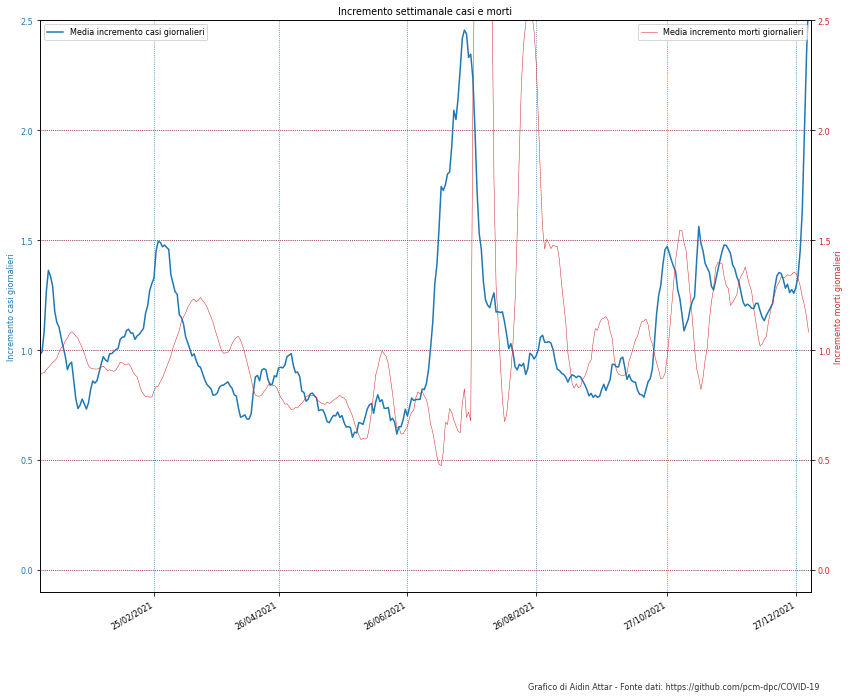

In [31]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
#ax1.scatter(x=Regioni['Emilia-Romagna'].index, y=Regioni['Emilia-Romagna'].incremento_casi_giornalieri,
#            s = 1, c = 'C0', marker = 'x', label = 'Incremento casi giornalieri')
ax1.plot(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].incremento_casi_giornalieri,
         color=color, label = 'Media incremento casi giornalieri')

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Incremento casi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax1.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.grid(linestyle='dotted',color=color)
ax1.set_ylim(bottom = -0.1, top=2.5)
ax1.set_title('Incremento settimanale casi e morti')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

#ax2.scatter(x=Regioni['Emilia-Romagna'].index, y=Regioni['Emilia-Romagna'].incremento_morti_giornalieri,
#            color = 'orange', s = 1, marker = '+', label = 'Incremento morti giornalieri')
ax2.plot(Regioni['Emilia-Romagna'].index, Regioni['Emilia-Romagna'].media_incremento_morti_giornalieri,
         color = color, linewidth = 0.5, label = 'Media incremento morti giornalieri')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid(linestyle='dotted', color=color)
ax2.set_ylim(bottom = -0.1, top=2.5)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Incremento morti giornalieri', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

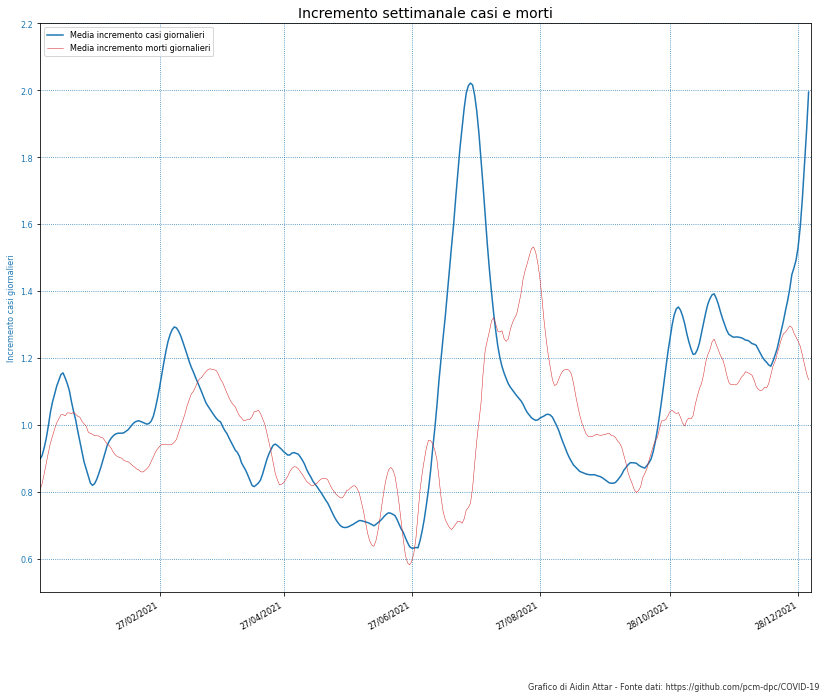

In [32]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.plot(italia.index, italia.media_incremento_casi_giornalieri,
         color=color, label = 'Media incremento casi giornalieri')

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Incremento casi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax1.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.grid(linestyle='dotted',color=color)
ax1.set_ylim(bottom = .5, top=2.2)
ax1.set_title('Incremento settimanale casi e morti', fontsize=14)

color = 'tab:red'
ax1.plot(italia.index, italia.media_incremento_morti_giornalieri,
         color = color, linewidth = 0.5, label = 'Media incremento morti giornalieri')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Incremento morti giornalieri', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

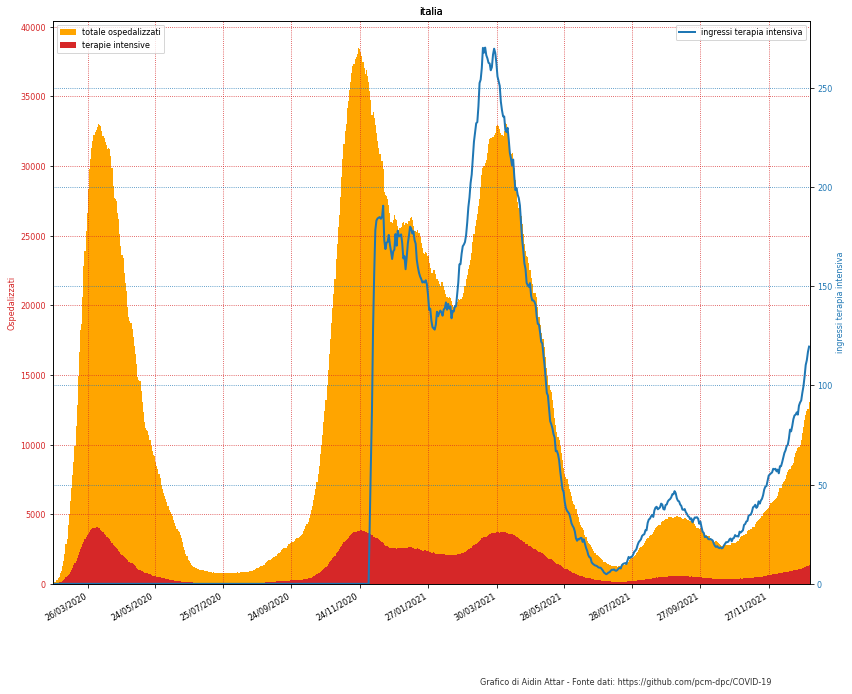

In [33]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:red'
italia.plot(ax = ax1, x ='data', y='totale_ospedalizzati',
            kind = 'bar', title = "italia", xlabel = '',
            color = 'orange', width = 1, label = 'totale ospedalizzati')
italia.plot(ax = ax1, x ='data', y='terapia_intensiva',
            kind = 'bar',xlabel = '', color = color,
            width = 1, label = 'terapie intensive')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('')
ax1.set_ylabel('Ospedalizzati', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
italia.plot(ax = ax2, y='media_ingressi_terapia_intensiva',
         kind = 'line',title = "italia",
         xlabel = '',  color=color,
         linewidth = 2, label = 'ingressi terapia intensiva')

fig.autofmt_xdate()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('ingressi terapia intensiva', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.rcParams['font.size'] = '12'
ax2.set_ylim(bottom = 0)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

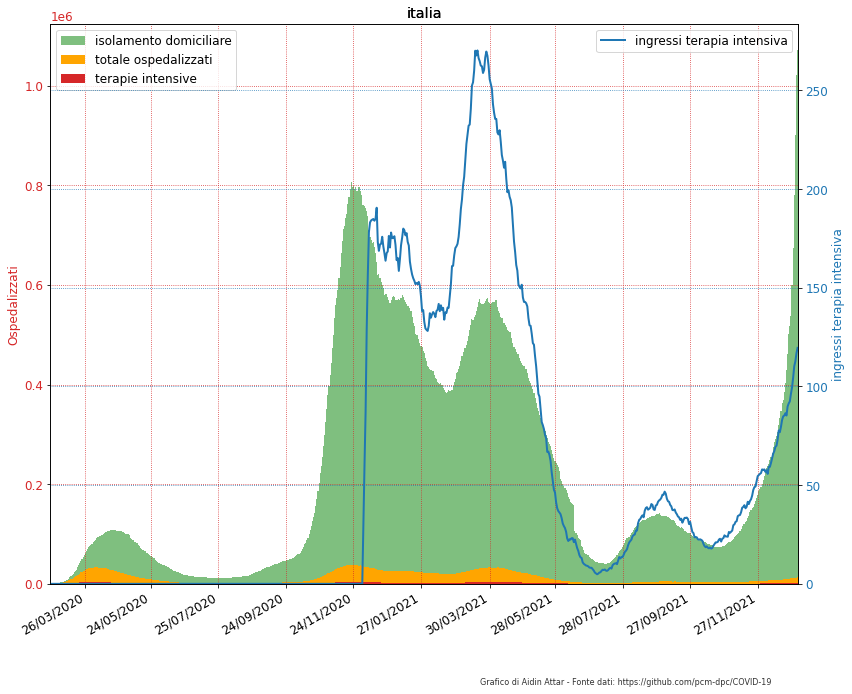

In [34]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:red'
italia.plot(ax = ax1, x ='data', y='totale_positivi',
            kind = 'bar',xlabel = '', color = 'green', alpha=0.5,
            width = 1, label = 'isolamento domiciliare')
italia.plot(ax = ax1, x ='data', y='totale_ospedalizzati',
            kind = 'bar', title = "italia", xlabel = '',
            color = 'orange', width = 1, label = 'totale ospedalizzati')
italia.plot(ax = ax1, x ='data', y='terapia_intensiva',
            kind = 'bar',xlabel = '', color = color,
            width = 1, label = 'terapie intensive')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('')
ax1.set_ylabel('Ospedalizzati', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
italia.plot(ax = ax2, y='media_ingressi_terapia_intensiva',
         kind = 'line',title = "italia",
         xlabel = '',  color=color,
         linewidth = 2, label = 'ingressi terapia intensiva')

fig.autofmt_xdate()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_xlabel('')
ax2.grid(linestyle='dotted', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('ingressi terapia intensiva', color=color)  # we already handled the x-label with ax1
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.rcParams['font.size'] = '12'
ax2.set_ylim(bottom = 0)

plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [35]:
italia[      'letalità'] = italia['morti_giornalieri'] / italia['casi_giornalieri'].shift(14) * 100
italia['media_letalità'] = italia['media_morti_giorn'] / italia['media_casi_giorn'].shift(14) * 100
italia['letalità_terapia_intensiva'] = italia['morti_giornalieri'] / italia['ingressi_terapia_intensiva'].shift(14) * 100
italia['media_letalità_terapia_intensiva'] = italia['media_morti_giorn'] / italia['media_ingressi_terapia_intensiva'].shift(14) * 100

italia

data stato  ricoverati_con_sintomi  \
24/02/2020 2020-02-24 18:00:00   ITA                     101   
25/02/2020 2020-02-25 18:00:00   ITA                     114   
26/02/2020 2020-02-26 18:00:00   ITA                     128   
27/02/2020 2020-02-27 18:00:00   ITA                     248   
28/02/2020 2020-02-28 18:00:00   ITA                     345   
...                        ...   ...                     ...   
29/12/2021 2021-12-29 17:00:00   ITA                   10578   
30/12/2021 2021-12-30 17:00:00   ITA                   10866   
31/12/2021 2021-12-31 17:00:00   ITA                   11150   
01/01/2022 2022-01-01 17:00:00   ITA                   11265   
02/01/2022 2022-01-02 17:00:00   ITA                   11756   

            terapia_intensiva  totale_ospedalizzati  isolamento_domiciliare  \
24/02/2020                 26                   127                      94   
25/02/2020                 35                   150                     162   
26/02/2020                 36                   164                     221   
27/02/2020                 56                   304                     284   
28/02/2020                 64                   409                     412   
...                       ...                   ...                     ...   
29/12/2021               1185                 11763                  663102   
30/12/2021               1226                 12092                  767371   
31/12/2021               1260                 12410                  888574   
01/01/2022               1297                 12562                 1009231   
02/01/2022               1319                 13075                 1057462   

            totale_positivi  variazione_totale_positivi  nuovi_positivi  \
24/02/2020              221                           0             221   
25/02/2020              311                          90              93   
26/02/2020              385                          74              78   
27/02/2020              588                         203             250   
28/02/2020              821                         233             238   
...                     ...                         ...             ...   
29/12/2021           674865                       75997           98030   
30/12/2021           779463                      104598          126888   
31/12/2021           900984                      121521          144243   
01/01/2022          1021793                      120809          141358   
02/01/2022          1070537                       48744           61046   

            dimessi_guariti  ...  tasso_antigenico_rapido  \
24/02/2020                1  ...                      NaN   
25/02/2020                1  ...                      NaN   
26/02/2020                3  ...                      NaN   
27/02/2020               45  ...                      NaN   
28/02/2020               46  ...                      NaN   
...                     ...  ...                      ...   
29/12/2021          5042472  ...                 5.347573   
30/12/2021          5064718  ...                 6.182755   
31/12/2021          5087297  ...                 7.514970   
01/01/2022          5107729  ...                 7.774561   
02/01/2022          5119893  ...                11.573018   

            media_tasso_antigenico_rapido  incremento_casi_giornalieri  \
24/02/2020                            NaN                          NaN   
25/02/2020                            NaN                          NaN   
26/02/2020                            NaN                          NaN   
27/02/2020                            NaN                          NaN   
28/02/2020                            NaN                          NaN   
...                                   ...                          ...   
29/12/2021                       3.288334                     2.006161   
30/12/2021                       3.888150                     2.223225   
31/12/20

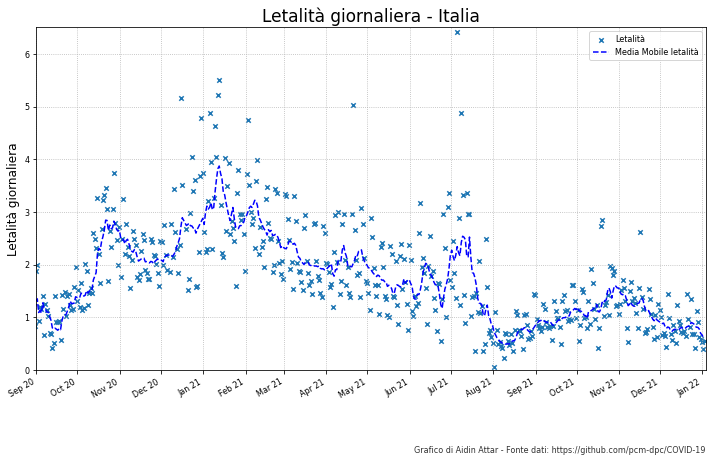

In [36]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='letalità',
            kind='scatter', marker = 'x', label='Letalità',  color='C0')
ax.plot(italia['data'], italia['media_letalità'],
        color = 'blue', label = 'Media Mobile letalità', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlim([date(2020, 9, 1), today])
ax.set_ylim(top = 6.5, bottom=0)
ax.set_title('Letalità giornaliera - Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Letalità giornaliera')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

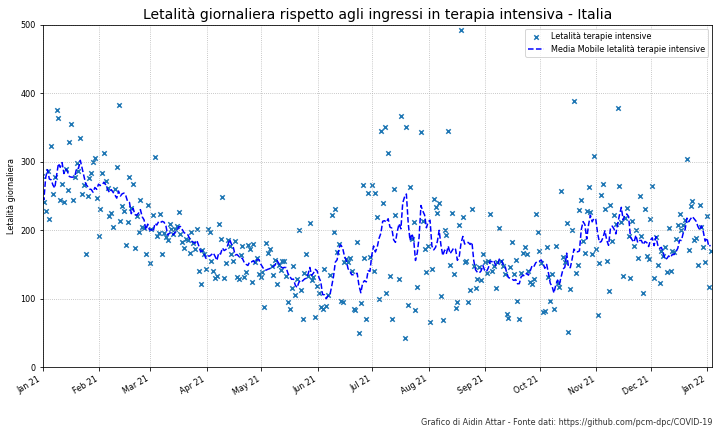

In [37]:
fig, ax = plt.subplots(figsize=(12, 7))

italia.plot(ax=ax, x ='data', y='letalità_terapia_intensiva',
            kind='scatter', marker = 'x', label='Letalità terapie intensive',  color='C0')
ax.plot(italia['data'], italia['media_letalità_terapia_intensiva'],
        color = 'blue', label = 'Media Mobile letalità terapie intensive', linestyle='dashed')
fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlim([date(2021, 1, 1), today])
ax.set_ylim(top = 500, bottom=0)
ax.set_title('Letalità giornaliera rispetto agli ingressi in terapia intensiva - Italia', fontsize=14)
plt.rcParams['font.size'] = '8'
ax.tick_params(axis='both', labelsize=8)
ax.grid(linestyle='dotted')
ax.set_ylabel('Letalità giornaliera')
ax.set_xlabel("")
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

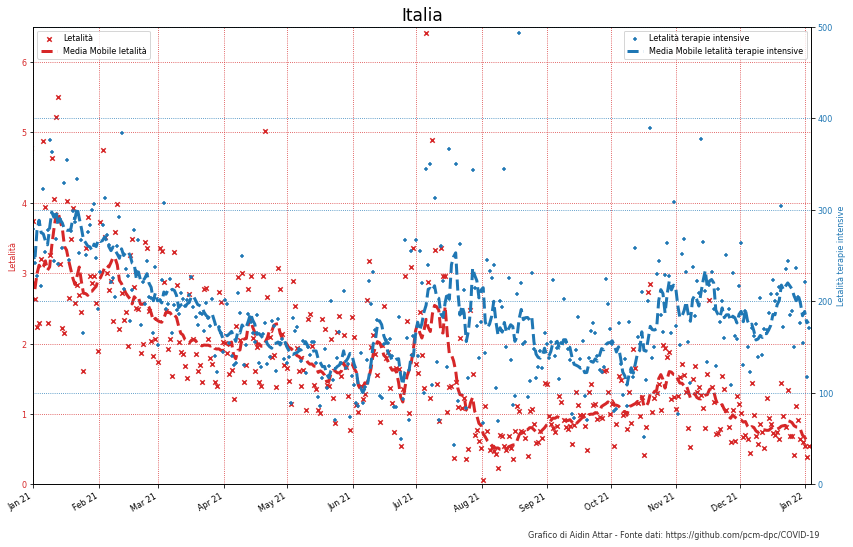

In [38]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
italia.plot(ax=ax1, x ='data', y='letalità',
            kind='scatter', marker = 'x', label='Letalità',  color=color)
ax1.plot(italia['data'], italia['media_letalità'], linewidth=3,
        color = color, label = 'Media Mobile letalità', linestyle='dashed')

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Letalità', color=color)
ax1.grid(linestyle='dotted',color=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'

italia.plot(ax=ax2, x ='data', y='letalità_terapia_intensiva',
            kind='scatter', marker = '+', label='Letalità terapie intensive',  color=color)
ax2.plot(italia['data'], italia['media_letalità_terapia_intensiva'], linewidth=3.,
         color = color, label = 'Media Mobile letalità terapie intensive', linestyle='dashed')

fig.autofmt_xdate()
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_title('Italia', fontsize=17)
plt.rcParams['font.size'] = '8'
ax1.legend(loc='upper left')

ax1.set_xlabel('')
ax2.set_ylabel('Letalità terapie intensive', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.legend(loc='upper right')

ax2.grid(linestyle='dotted', color=color)

ax1.set_xlim([date(2021, 1, 1), today])
ax2.set_ylim(top = 500, bottom=0)
ax1.set_ylim(top = 6.5, bottom=0)

plt.text(0.95, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [39]:
italia[          'variazione_ospedalizzati'] = italia[        'totale_ospedalizzati'] - italia['totale_ospedalizzati'].shift(1)
italia[             'variazione_ricoverati'] = italia[      'ricoverati_con_sintomi'] - italia[   'ricoverati_con_sintomi'].shift(1)
italia[      'variazione_terapie_intensive'] = italia[           'terapia_intensiva'] - italia[   'terapia_intensiva'].shift(1)

italia[          'media_variazione_ospedalizzati'] = italia[          'totale_ospedalizzati'].rolling(window=7, min_periods=1).mean()
italia[             'media_variazione_ricoverati'] = italia[             'ricoverati_con_sintomi'].rolling(window=7, min_periods=1).mean()
italia[      'media_variazione_terapie_intensive'] = italia[      'terapia_intensiva'].rolling(window=7, min_periods=1).mean()

italia[          'incremento_ospedalizzati'] = italia[    'media_variazione_ospedalizzati'] / italia[   'media_variazione_ospedalizzati'].shift(7)
italia[             'incremento_ricoverati'] = italia[       'media_variazione_ricoverati'] / italia[   'media_variazione_ricoverati'].shift(7)
italia[      'incremento_terapie_intensive'] = italia['media_variazione_terapie_intensive'] / italia[   'media_variazione_terapie_intensive'].shift(7)

italia[    'media_incremento_ospedalizzati'] = italia['incremento_ospedalizzati'].rolling(window=15, min_periods=1).mean()
italia[       'media_incremento_ricoverati'] = italia['incremento_ricoverati'].rolling(window=15, min_periods=1).mean()
italia['media_incremento_terapie_intensive'] = italia['incremento_terapie_intensive'].rolling(window=15, min_periods=1).mean()


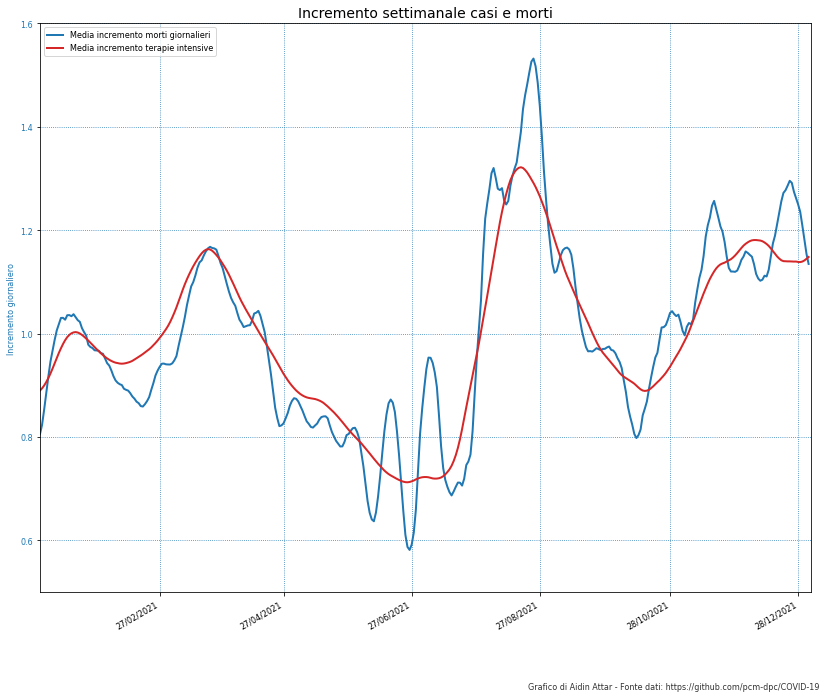

In [40]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.plot(italia.index, italia.media_incremento_morti_giornalieri,
         color = color, linewidth = 2, label = 'Media incremento morti giornalieri')

ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Incremento giornaliero', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax1.set_xlim([date(2021, 1, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.grid(linestyle='dotted',color=color)
#ax1.set_ylim(bottom = -5, top=5)
ax1.set_title('Incremento settimanale casi e morti', fontsize=14)

color = 'tab:red'
ax1.plot(italia.index, italia.media_incremento_terapie_intensive,
         color = color, linewidth = 2, label = 'Media incremento terapie intensive')

fig.autofmt_xdate()
ax1.set_ylim(bottom = .5, top=1.6)
ax1.legend(loc='upper left')
#ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.rcParams['font.size'] = '8'

plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

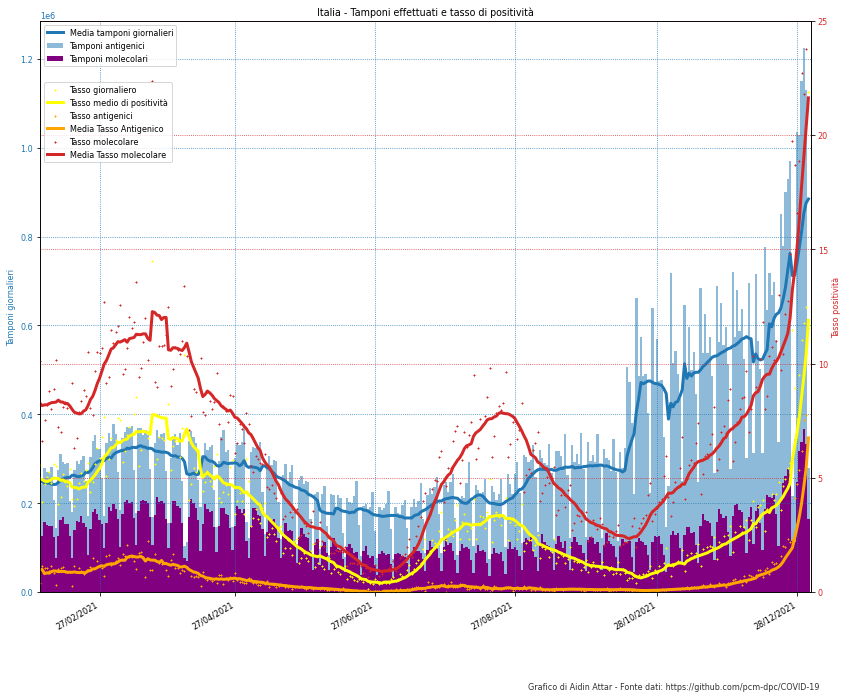

In [41]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(italia.index, italia.tamponi_giornalieri,
        color='C0', width=1, label='Tamponi antigenici', alpha=0.5)
ax1.bar(italia.index, italia.tamponi_test_molecolare_giorn,
        color='purple', width=1, label='Tamponi molecolari', alpha=1)
ax1.plot(italia.index, italia.media_tamponi, lw=3,
         color=color, label = 'Media tamponi giornalieri')

ax1.set_xlim([date(2021, 2, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Italia - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=italia.index, y=italia.tasso_positivi,
            color = 'yellow', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(italia.index, italia.media_tasso_positivi,
         color = 'yellow', linewidth = 3, label = 'Tasso medio di positività')
ax2.scatter(x=italia.index, y=italia.tasso_antigenico_rapido,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso antigenici')
ax2.plot(italia.index, italia.media_tasso_antigenico_rapido,
         color = 'orange', linewidth = 3, label = 'Media Tasso Antigenico')
ax2.scatter(x=italia.index, y=italia.tasso_molecolare,
            color = color, s = 1, marker = 'x', label = 'Tasso molecolare')
ax2.plot(italia.index, italia.media_tasso_molecolare,
         color = color, linewidth = 3, label = 'Media Tasso molecolare')

fig.autofmt_xdate()
ax1.legend(loc='upper left')

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0, top=25)
ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
ax1.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

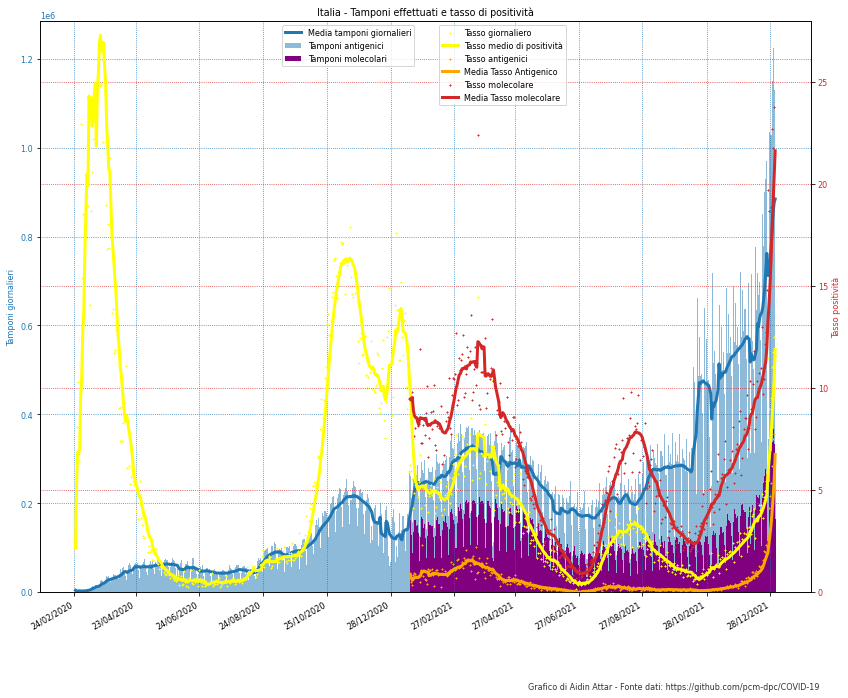

In [42]:
fig, ax1 = plt.subplots(figsize=(12,10))

color = 'tab:blue'
ax1.bar(italia.index, italia.tamponi_giornalieri,
        color='C0', width=1, label='Tamponi antigenici', alpha=0.5)
ax1.bar(italia.index, italia.tamponi_test_molecolare_giorn,
        color='purple', width=1, label='Tamponi molecolari', alpha=1)
ax1.plot(italia.index, italia.media_tamponi, lw=3,
         color=color, label = 'Media tamponi giornalieri')

#ax1.set_xlim([date(2021, 2, 1).strftime('%d/%m/%Y'), today.strftime('%d/%m/%Y')])
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(ls = 'dotted')
ax1.set_xlabel('')
ax1.set_ylabel('Tamponi giornalieri', color=color)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.set_title('Italia - Tamponi effettuati e tasso di positività')

#ax1.set_xlim([date(2021, 10, 1).strftime('%d/%m/%Y'), today])
ax1.grid(linestyle='dotted',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'

ax2.scatter(x=italia.index, y=italia.tasso_positivi,
            color = 'yellow', s = 1, marker = 'x', label = 'Tasso giornaliero')
ax2.plot(italia.index, italia.media_tasso_positivi,
         color = 'yellow', linewidth = 3, label = 'Tasso medio di positività')
ax2.scatter(x=italia.index, y=italia.tasso_antigenico_rapido,
            color = 'orange', s = 1, marker = 'x', label = 'Tasso antigenici')
ax2.plot(italia.index, italia.media_tasso_antigenico_rapido,
         color = 'orange', linewidth = 3, label = 'Media Tasso Antigenico')
ax2.scatter(x=italia.index, y=italia.tasso_molecolare,
            color = color, s = 1, marker = 'x', label = 'Tasso molecolare')
ax2.plot(italia.index, italia.media_tasso_molecolare,
         color = color, linewidth = 3, label = 'Media Tasso molecolare')

fig.autofmt_xdate()

ax2.set_xlabel('')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0, top=28)
ax2.grid(linestyle='dotted', color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Tasso positività', color=color)  # we already handled the x-label with ax1

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#ax2.set_ylim(top=80)

plt.rcParams['font.size'] = '8'
plt.text(0.95, 0.05, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19', 
         transform=plt.gcf().transFigure,
         fontsize=8, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

ax1.legend(loc='upper center', bbox_to_anchor=(0.4, 1))
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, 1))
ax1.set_ylim(bottom=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [43]:
italy = gpd.read_file('../mappe/italy-with-regions/reg2011_g.shp')
oggi = [Regioni[key].iloc[-2] for key in Regioni.keys()]
cum = pd.DataFrame(oggi)

cum1 = cum.set_index('denominazione_regione')
sum_ = cum1.reindex(['P.A. Trento', 'P.A. Bolzano']).sum().to_frame().transpose()
sum_ = sum_.rename(index={0: 'Trentino-Alto Adige/Sudtirol'})
cum1.drop(['P.A. Trento', 'P.A. Bolzano'],inplace=True)
cum1 = cum1.append(sum_)
cum1 = cum1.sort_index()
italy.sort_values(by = 'NOME_REG', inplace = True)
italy.reset_index(drop=True,       inplace = True)
italy.index = cum1.index

italy = italy.merge(cum1,left_index=True, right_index=True, how='right')
italy.at['Trentino-Alto Adige/Sudtirol',                  'media_morti_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol',                  'media_morti_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol',                   'media_casi_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol',                   'media_casi_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol',                      'media_tamponi_norm'] = italy.at['Trentino-Alto Adige/Sudtirol',                      'media_tamponi'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol','media_tamponi_test_molecolare_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol','media_tamponi_test_molecolare_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000
italy.at['Trentino-Alto Adige/Sudtirol', 'media_test_antigenico_rapido_giorn_norm'] = italy.at['Trentino-Alto Adige/Sudtirol', 'media_test_antigenico_rapido_giorn'] / (DictRegioni['P.A. Bolzano']+DictRegioni['P.A. Trento'])*100000

/tmp/ipykernel_48709/2219818054.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_ = cum1.reindex(['P.A. Trento', 'P.A. Bolzano']).sum().to_frame().transpose()


Text(0.85, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

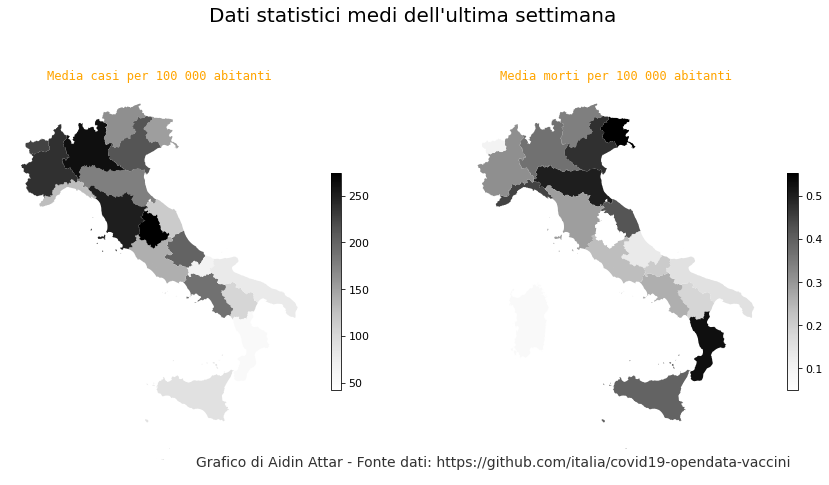

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
col1 = 'media_casi_giorn_norm'
ax[0].set_title('Media casi per 100 000 abitanti',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy[col1].min(), vmax=italy[col1].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[0],
           column=col1,
           cmap="Greys")
plt.axis('off')
cbar = plt.colorbar(scalarmappaple1, ax=ax[0],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'media_morti_giorn_norm'
ax[1].set_title('Media morti per 100 000 abitanti',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy[col2].min(), vmax=italy[col2].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[1],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[1],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

ax[0].axis('off')
ax[1].axis('off')
fig.suptitle("Dati statistici medi dell'ultima settimana", fontsize=20)
plt.text(0.85, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

In [45]:
metriche_mobile = pd.read_csv('../metriche/dpc-covid19-ita-metriche-dashboard-mobile.csv')
metriche_desktop = pd.read_csv('../metriche/dpc-covid19-ita-metriche-dashboard-desktop.csv', encoding='latin-1')

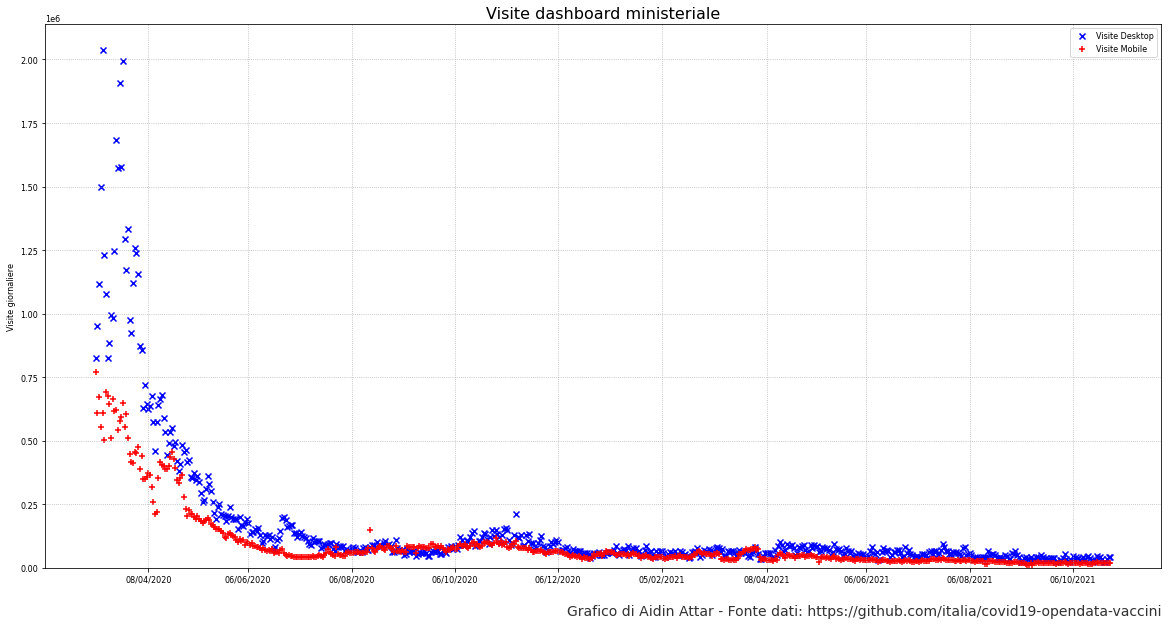

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(metriche_desktop.data, metriche_desktop.totale_visitatori_giorno, label='Visite Desktop', color='blue', marker='x')
ax.scatter(metriche_mobile.data,   metriche_mobile.totale_visitatori_giorno, label= 'Visite Mobile', color= 'red', marker='+')
ax.set_title('Visite dashboard ministeriale', fontsize=16)
ax.set_ylabel('Visite giornaliere')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.grid(linestyle='dotted')
ax.set_ylim(bottom=0)
ax.legend(loc='upper right')
plt.text(0.9, 0.075, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

Text(0.9, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini')

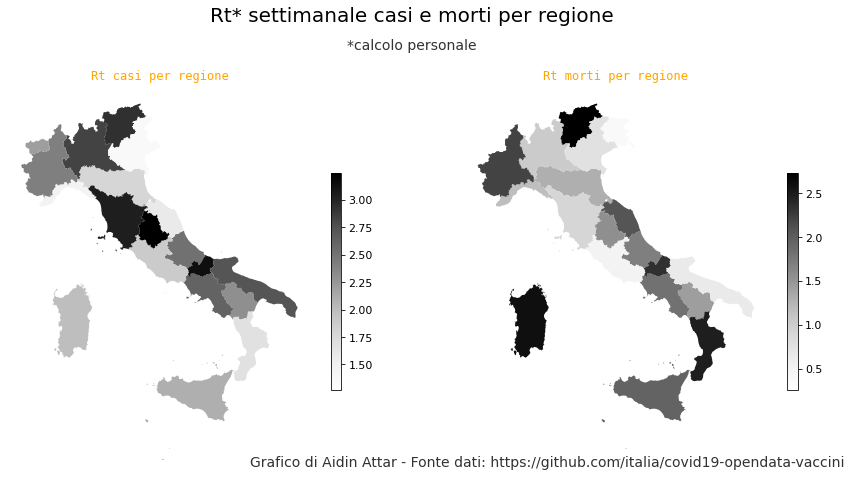

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
col1 = 'media_incremento_casi_giornalieri'
ax[0].set_title('Rt casi per regione',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize1 = mcolors.Normalize(vmin=italy[col1].min(), vmax=italy[col1].max())
scalarmappaple1 = cm.ScalarMappable(norm=normalize1, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[0],
           column=col1,
           cmap="Greys")
plt.axis('off')
cbar = plt.colorbar(scalarmappaple1, ax=ax[0],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

col2 = 'media_incremento_morti_giornalieri'
ax[1].set_title('Rt morti per regione',
             fontdict={'fontsize':'12', 'fontweight':'3'},
             color='Orange',
             fontfamily='monospace')


normalize2 = mcolors.Normalize(vmin=italy[col2].min(), vmax=italy[col2].max())
scalarmappaple2 = cm.ScalarMappable(norm=normalize2, cmap="Greys")
#scalarmappaple.set_array(italy['cumulativa_totale_per100'])

italy.plot(ax=ax[1],
           column=col2,
           cmap="Greys")
cbar = plt.colorbar(scalarmappaple2, ax=ax[1],shrink=0.5)
cbar.ax.tick_params(labelsize=11)

ax[0].axis('off')
ax[1].axis('off')
fig.suptitle("Rt* settimanale casi e morti per regione", fontsize=20)
plt.text(0.5, 0.925, '*calcolo personale',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='center', va='top', rotation='0')
plt.text(0.9, 0.2, 'Grafico di Aidin Attar - Fonte dati: https://github.com/italia/covid19-opendata-vaccini',
         transform=plt.gcf().transFigure,
         fontsize=14, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')

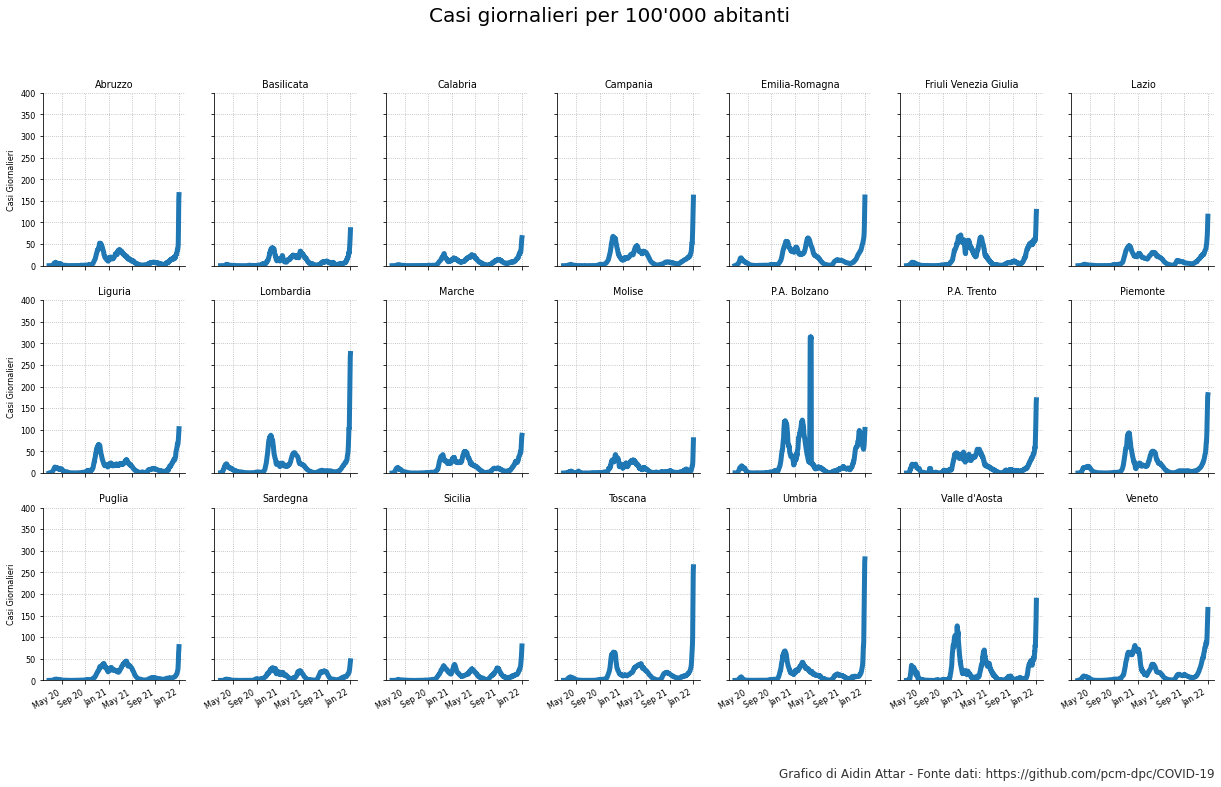

In [48]:
fig, ax = plt.subplots(nrows=3, ncols=7, sharey=True, figsize=(21, 12))

x = 0
y = 0
for key in Regioni.keys():
    ax[y,x].plot(Regioni[key].data, Regioni[key]['media_casi_giorn_norm'],c='C0', lw=5)
    #ax[y,x].plot(Regioni[key]['data'], Regioni[key]['media_morti_giorn_norm'],c='orange')
    ax[y,x].set_title(key)
    ax[y,x].grid(linestyle='dotted')
    ax[y,x].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax[y,x].spines['right'].set_visible(False)
    ax[y,x].spines['top'].set_visible(False)
    ax[y,x].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    ax[y,x].xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
    x += 1
    if x == 7:
        y +=1
        x = 0
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Casi Giornalieri')
ax[1,0].set_ylabel('Casi Giornalieri')
ax[2,0].set_ylabel('Casi Giornalieri')
fig.autofmt_xdate()
fig.suptitle("Casi giornalieri per 100'000 abitanti", fontsize=20)
ax[0,0].set_ylim(bottom=0, top=400)

plt.text(0.9, 0.1, 'Grafico di Aidin Attar - Fonte dati: https://github.com/pcm-dpc/COVID-19',
         transform=plt.gcf().transFigure,
         fontsize=12, color='black', alpha=0.8,
         ha='right', va='top', rotation='0')
plt.show()

In [95]:
ISSpath = '../ISS/covid_19-iss.xlsx'
!curl --output ../ISS/covid_19-iss.xlsx https://www.epicentro.iss.it/coronavirus/open-data/covid_19-iss.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  104k  100  104k    0     0   212k      0 --:--:-- --:--:-- --:--:--  212k


In [103]:
# Numero casi per data prelievo/diagnosi aggiornati alla data riportata in iss_date
ISS_prelievo_diagnosi   = pd.read_excel(ISSpath, sheet_name='casi_prelievo_diagnosi'  )

# Numero casi per data inizio sintomi aggiornati alla data riportata in iss_date
ISS_inizio_sintomi      = pd.read_excel(ISSpath, sheet_name='casi_inizio_sintomi'     )

# Numero casi per data inizio sintomi  i casi di infezione confermata da virus SARS-CoV-2 per cui
# è indicata una data inizio sintomi tranne i casi dichiarati asintomatici aggiornati alla data riportata in iss_date
ISS_inizio_sintomi_sint = pd.read_excel(ISSpath, sheet_name='casi_inizio_sintomi_sint')

# Numero totale casi dall'inizio dell'epidemia per regione/PA di diagnosi aggiornati alla data riportata in iss_date
ISS_casi_regioni        = pd.read_excel(ISSpath, sheet_name='casi_regioni'            )

# Numero totale casi dall'inizio dell'epidemia per provincia di domicilio/residenza aggiornati alla data riportata in iss_date
ISS_casi_provincie      = pd.read_excel(ISSpath, sheet_name='casi_provincie'          )

# Numero ricoveri per data di ricovero aggiornati alla data riportata in iss_date
ISS_ricoveri            = pd.read_excel(ISSpath, sheet_name='ricoveri'                )

# Numero decessi per data di decesso aggiornati alla data riportata in iss_date
ISS_decessi             = pd.read_excel(ISSpath, sheet_name='decessi'                 )

# Numero totale casi e decessi dall'inizio dell'epidemia per sesso e per fascia d'età aggiornati alla data riportata in iss_date
ISS_sesso_età           = pd.read_excel(ISSpath, sheet_name='sesso_eta'               )

# Numero totale casi con malattia ancora in corso e con esito finale ancora non definito dall'inizio
# dell'epidemia, differenziati per sintomatologia più recente, per sesso e per fascia d'età aggiornati alla data riportata in iss_date
ISS_stato_clinico       = pd.read_excel(ISSpath, sheet_name='stato_clinico'           )

In [130]:
ISS_prelievo_diagnosi.loc[  ISS_prelievo_diagnosi[       'CASI']=='<5',     'CASI']=5
ISS_inizio_sintomi.loc[     ISS_inizio_sintomi[          'CASI']=='<5',     'CASI']=5
ISS_inizio_sintomi_sint.loc[ISS_inizio_sintomi_sint['CASI_SINT']=='<5','CASI_SINT']=5
ISS_ricoveri.loc[           ISS_ricoveri[            'RICOVERI']=='<5', 'RICOVERI']=5
ISS_decessi.loc[            ISS_decessi[              'DECESSI']=='<5',  'DECESSI']=5

ISS_prelievo_diagnosi['DATA_PRELIEVO_DIAGNOSI'] = pd.to_datetime(ISS_prelievo_diagnosi['DATA_PRELIEVO_DIAGNOSI'],format='%d/%m/%Y', dayfirst=True)
ISS_inizio_sintomi[      'DATA_INIZIO_SINTOMI'] = pd.to_datetime(ISS_inizio_sintomi[      'DATA_INIZIO_SINTOMI'],format='%d/%m/%Y', dayfirst=True)
ISS_inizio_sintomi_sint[ 'DATA_INIZIO_SINTOMI'] = pd.to_datetime(ISS_inizio_sintomi[      'DATA_INIZIO_SINTOMI'],format='%d/%m/%Y', dayfirst=True)
ISS_ricoveri[                  'DATARICOVERO1'] = pd.to_datetime(ISS_ricoveri[                  'DATARICOVERO1'],format='%d/%m/%Y', dayfirst=True)
ISS_decessi[                    'DATA_DECESSO'] = pd.to_datetime(ISS_decessi[                    'DATA_DECESSO'],format='%d/%m/%Y', dayfirst=True)
ISS_decessi.DECESSI = ISS_decessi.DECESSI.astype(int)

ISS_decessi['new_date']                         = ISS_decessi['DATA_DECESSO'].dt.date
ISS_decessi                                     = ISS_decessi.set_index('new_date')
ISS_decessi                                     = ISS_decessi.reindex(idx)
ISS_decessi.index                               = ISS_decessi.index.strftime('%d/%m/%Y')

Text(0, 0.5, 'Differenza decessi giornalieri comunicati ed effettivi')

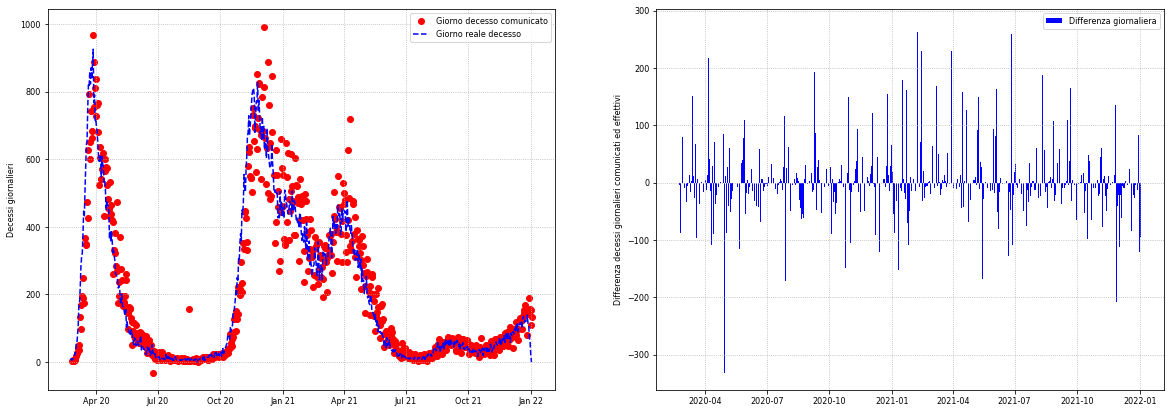

In [139]:
fig, ax = plt.subplots(ncols=2,figsize=(20,7))
ax[0].scatter(italia.data,italia.morti_giornalieri, label='Giorno decesso comunicato', color='red')
ax[0].plot(ISS_decessi.DATA_DECESSO,ISS_decessi.DECESSI, label='Giorno reale decesso', color='blue', linestyle='dashed')
ax[0].grid(linestyle='dotted')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Decessi giornalieri')

ax[1].bar(ISS_decessi.DATA_DECESSO, ISS_decessi.DECESSI-italia.morti_giornalieri, label='Differenza giornaliera', color='blue')
ax[1].grid(linestyle='dotted')
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%b %y"))
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Differenza decessi giornalieri comunicati ed effettivi')